# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: min


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:16:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:16:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:16:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:16:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:16:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.808257617854855
Average Accuracy: 0.750399506189774
Average Precision: 0.7029021386229786
Average Recall: 0.6288241881298993


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8061830347196632
Average Accuracy: 0.7462741332601762
Average Precision: 0.6989025395506492
Average Recall: 0.6202911534154536


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66615


[1]	validation_0-logloss:0.66347


[2]	validation_0-logloss:0.66106


[3]	validation_0-logloss:0.65849


[4]	validation_0-logloss:0.65651


[5]	validation_0-logloss:0.65406


[6]	validation_0-logloss:0.65162


[7]	validation_0-logloss:0.64941


[8]	validation_0-logloss:0.64731


[9]	validation_0-logloss:0.64505


[10]	validation_0-logloss:0.64243


[11]	validation_0-logloss:0.64078


[12]	validation_0-logloss:0.63846


[13]	validation_0-logloss:0.63643


[14]	validation_0-logloss:0.63420


[15]	validation_0-logloss:0.63172


[16]	validation_0-logloss:0.62966


[17]	validation_0-logloss:0.62761


[18]	validation_0-logloss:0.62625


[19]	validation_0-logloss:0.62471


[20]	validation_0-logloss:0.62299


[21]	validation_0-logloss:0.62080


[22]	validation_0-logloss:0.61914


[23]	validation_0-logloss:0.61711


[24]	validation_0-logloss:0.61529


[25]	validation_0-logloss:0.61356


[26]	validation_0-logloss:0.61206


[27]	validation_0-logloss:0.61013


[28]	validation_0-logloss:0.60860


[29]	validation_0-logloss:0.60669


[30]	validation_0-logloss:0.60570


[31]	validation_0-logloss:0.60416


[32]	validation_0-logloss:0.60210


[33]	validation_0-logloss:0.60092


[34]	validation_0-logloss:0.59943


[35]	validation_0-logloss:0.59795


[36]	validation_0-logloss:0.59635


[37]	validation_0-logloss:0.59492


[38]	validation_0-logloss:0.59372


[39]	validation_0-logloss:0.59235


[40]	validation_0-logloss:0.59115


[41]	validation_0-logloss:0.58944


[42]	validation_0-logloss:0.58812


[43]	validation_0-logloss:0.58699


[44]	validation_0-logloss:0.58588


[45]	validation_0-logloss:0.58465


[46]	validation_0-logloss:0.58350


[47]	validation_0-logloss:0.58265


[48]	validation_0-logloss:0.58178


[49]	validation_0-logloss:0.58035


[50]	validation_0-logloss:0.57920


[51]	validation_0-logloss:0.57806


[52]	validation_0-logloss:0.57666


[53]	validation_0-logloss:0.57543


[54]	validation_0-logloss:0.57438


[55]	validation_0-logloss:0.57277


[56]	validation_0-logloss:0.57167


[57]	validation_0-logloss:0.57066


[58]	validation_0-logloss:0.56969


[59]	validation_0-logloss:0.56858


[60]	validation_0-logloss:0.56762


[61]	validation_0-logloss:0.56640


[62]	validation_0-logloss:0.56481


[63]	validation_0-logloss:0.56359


[64]	validation_0-logloss:0.56284


[65]	validation_0-logloss:0.56161


[66]	validation_0-logloss:0.56034


[67]	validation_0-logloss:0.55947


[68]	validation_0-logloss:0.55840


[69]	validation_0-logloss:0.55700


[70]	validation_0-logloss:0.55594


[71]	validation_0-logloss:0.55507


[72]	validation_0-logloss:0.55438


[73]	validation_0-logloss:0.55306


[74]	validation_0-logloss:0.55222


[75]	validation_0-logloss:0.55168


[76]	validation_0-logloss:0.55086


[77]	validation_0-logloss:0.55008


[78]	validation_0-logloss:0.54937


[79]	validation_0-logloss:0.54875


[80]	validation_0-logloss:0.54776


[81]	validation_0-logloss:0.54675


[82]	validation_0-logloss:0.54598


[83]	validation_0-logloss:0.54504


[84]	validation_0-logloss:0.54419


[85]	validation_0-logloss:0.54328


[86]	validation_0-logloss:0.54261


[87]	validation_0-logloss:0.54160


[88]	validation_0-logloss:0.54100


[89]	validation_0-logloss:0.54041


[90]	validation_0-logloss:0.53972


[91]	validation_0-logloss:0.53901


[92]	validation_0-logloss:0.53836


[93]	validation_0-logloss:0.53776


[94]	validation_0-logloss:0.53712


[95]	validation_0-logloss:0.53685


[96]	validation_0-logloss:0.53616


[97]	validation_0-logloss:0.53561


[98]	validation_0-logloss:0.53502


[99]	validation_0-logloss:0.53439


[100]	validation_0-logloss:0.53417


[101]	validation_0-logloss:0.53370


[102]	validation_0-logloss:0.53268


[103]	validation_0-logloss:0.53204


[104]	validation_0-logloss:0.53154


[105]	validation_0-logloss:0.53066


[106]	validation_0-logloss:0.52991


[107]	validation_0-logloss:0.52946


[108]	validation_0-logloss:0.52918


[109]	validation_0-logloss:0.52878


[110]	validation_0-logloss:0.52844


[111]	validation_0-logloss:0.52806


[112]	validation_0-logloss:0.52796


[113]	validation_0-logloss:0.52747


[114]	validation_0-logloss:0.52686


[115]	validation_0-logloss:0.52643


[116]	validation_0-logloss:0.52601


[117]	validation_0-logloss:0.52577


[118]	validation_0-logloss:0.52576


[119]	validation_0-logloss:0.52526


[120]	validation_0-logloss:0.52498


[121]	validation_0-logloss:0.52452


[122]	validation_0-logloss:0.52380


[123]	validation_0-logloss:0.52348


[124]	validation_0-logloss:0.52306


[125]	validation_0-logloss:0.52271


[126]	validation_0-logloss:0.52233


[127]	validation_0-logloss:0.52194


[128]	validation_0-logloss:0.52139


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:17:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[129]	validation_0-logloss:0.52102


[130]	validation_0-logloss:0.52025


[131]	validation_0-logloss:0.51976


[132]	validation_0-logloss:0.51926


[133]	validation_0-logloss:0.51874


[134]	validation_0-logloss:0.51852


[135]	validation_0-logloss:0.51843


[136]	validation_0-logloss:0.51807


[137]	validation_0-logloss:0.51769


[138]	validation_0-logloss:0.51705


[139]	validation_0-logloss:0.51658


[140]	validation_0-logloss:0.51659


[141]	validation_0-logloss:0.51642


[142]	validation_0-logloss:0.51543


[143]	validation_0-logloss:0.51529


[144]	validation_0-logloss:0.51495


[145]	validation_0-logloss:0.51446


[146]	validation_0-logloss:0.51417


[147]	validation_0-logloss:0.51354


[148]	validation_0-logloss:0.51316


[149]	validation_0-logloss:0.51318


[150]	validation_0-logloss:0.51275


[151]	validation_0-logloss:0.51268


[152]	validation_0-logloss:0.51281


[153]	validation_0-logloss:0.51263


[154]	validation_0-logloss:0.51242


[155]	validation_0-logloss:0.51182


[156]	validation_0-logloss:0.51151


[157]	validation_0-logloss:0.51135


[158]	validation_0-logloss:0.51087


[159]	validation_0-logloss:0.51025


[160]	validation_0-logloss:0.50971

[161]	validation_0-logloss:0.50954


[162]	validation_0-logloss:0.50945


[163]	validation_0-logloss:0.50924


[164]	validation_0-logloss:0.50872


[165]	validation_0-logloss:0.50897


[166]	validation_0-logloss:0.50884


[167]	validation_0-logloss:0.50869


[168]	validation_0-logloss:0.50867


[169]	validation_0-logloss:0.50848


[170]	validation_0-logloss:0.50787


[171]	validation_0-logloss:0.50764


[172]	validation_0-logloss:0.50731


[173]	validation_0-logloss:0.50715


[174]	validation_0-logloss:0.50715


[175]	validation_0-logloss:0.50667


[176]	validation_0-logloss:0.50652


[177]	validation_0-logloss:0.50611


[178]	validation_0-logloss:0.50580


[179]	validation_0-logloss:0.50558


[180]	validation_0-logloss:0.50514


[181]	validation_0-logloss:0.50471


[182]	validation_0-logloss:0.50439


[183]	validation_0-logloss:0.50442


[184]	validation_0-logloss:0.50423

[185]	validation_0-logloss:0.50441


[186]	validation_0-logloss:0.50410


[187]	validation_0-logloss:0.50380


[188]	validation_0-logloss:0.50374

[189]	validation_0-logloss:0.50355


[190]	validation_0-logloss:0.50350


[191]	validation_0-logloss:0.50306


[192]	validation_0-logloss:0.50275


[193]	validation_0-logloss:0.50247


[194]	validation_0-logloss:0.50250


[195]	validation_0-logloss:0.50223


[196]	validation_0-logloss:0.50232


[197]	validation_0-logloss:0.50239


[198]	validation_0-logloss:0.50234


[199]	validation_0-logloss:0.50254


[200]	validation_0-logloss:0.50225


[201]	validation_0-logloss:0.50227


[202]	validation_0-logloss:0.50191


[203]	validation_0-logloss:0.50162


[204]	validation_0-logloss:0.50142


[205]	validation_0-logloss:0.50169


[206]	validation_0-logloss:0.50151


[207]	validation_0-logloss:0.50143


[208]	validation_0-logloss:0.50113


[209]	validation_0-logloss:0.50136


[210]	validation_0-logloss:0.50120


[211]	validation_0-logloss:0.50122


[212]	validation_0-logloss:0.50077


[213]	validation_0-logloss:0.50043


[214]	validation_0-logloss:0.50024


[215]	validation_0-logloss:0.50027


[216]	validation_0-logloss:0.50016


[217]	validation_0-logloss:0.50000


[218]	validation_0-logloss:0.49997


[219]	validation_0-logloss:0.49997


[220]	validation_0-logloss:0.49968


[221]	validation_0-logloss:0.49956


[222]	validation_0-logloss:0.49940


[223]	validation_0-logloss:0.49942


[224]	validation_0-logloss:0.49970


[225]	validation_0-logloss:0.49954


[226]	validation_0-logloss:0.49949


[227]	validation_0-logloss:0.49937


[228]	validation_0-logloss:0.49918


[229]	validation_0-logloss:0.49905


[230]	validation_0-logloss:0.49876

[231]	validation_0-logloss:0.49878


[232]	validation_0-logloss:0.49868


[233]	validation_0-logloss:0.49865


[234]	validation_0-logloss:0.49862


[235]	validation_0-logloss:0.49833


[236]	validation_0-logloss:0.49834


[237]	validation_0-logloss:0.49798


[238]	validation_0-logloss:0.49758


[239]	validation_0-logloss:0.49747


[240]	validation_0-logloss:0.49727


[241]	validation_0-logloss:0.49720


[242]	validation_0-logloss:0.49701


[243]	validation_0-logloss:0.49712


[244]	validation_0-logloss:0.49691


[245]	validation_0-logloss:0.49664


[246]	validation_0-logloss:0.49616


[247]	validation_0-logloss:0.49605


[248]	validation_0-logloss:0.49602


[249]	validation_0-logloss:0.49609


[250]	validation_0-logloss:0.49603


[251]	validation_0-logloss:0.49619


[252]	validation_0-logloss:0.49597


[253]	validation_0-logloss:0.49576


[254]	validation_0-logloss:0.49562


[255]	validation_0-logloss:0.49547

[256]	validation_0-logloss:0.49528


[257]	validation_0-logloss:0.49502


[258]	validation_0-logloss:0.49512


[259]	validation_0-logloss:0.49491

[260]	validation_0-logloss:0.49506


[261]	validation_0-logloss:0.49514


[262]	validation_0-logloss:0.49514


[263]	validation_0-logloss:0.49532


[264]	validation_0-logloss:0.49492


[265]	validation_0-logloss:0.49506


[266]	validation_0-logloss:0.49520


[267]	validation_0-logloss:0.49515

[268]	validation_0-logloss:0.49496


[269]	validation_0-logloss:0.49494


[0]	validation_0-logloss:0.66782


[1]	validation_0-logloss:0.66572


[2]	validation_0-logloss:0.66313


[3]	validation_0-logloss:0.66074


[4]	validation_0-logloss:0.65802


[5]	validation_0-logloss:0.65584


[6]	validation_0-logloss:0.65382


[7]	validation_0-logloss:0.65148


[8]	validation_0-logloss:0.64995


[9]	validation_0-logloss:0.64754


[10]	validation_0-logloss:0.64561


[11]	validation_0-logloss:0.64398


[12]	validation_0-logloss:0.64219


[13]	validation_0-logloss:0.64037


[14]	validation_0-logloss:0.63829


[15]	validation_0-logloss:0.63638


[16]	validation_0-logloss:0.63461


[17]	validation_0-logloss:0.63281


[18]	validation_0-logloss:0.63139


[19]	validation_0-logloss:0.63002


[20]	validation_0-logloss:0.62849


[21]	validation_0-logloss:0.62638


[22]	validation_0-logloss:0.62491


[23]	validation_0-logloss:0.62297


[24]	validation_0-logloss:0.62140


[25]	validation_0-logloss:0.61990


[26]	validation_0-logloss:0.61834


[27]	validation_0-logloss:0.61670


[28]	validation_0-logloss:0.61480


[29]	validation_0-logloss:0.61336


[30]	validation_0-logloss:0.61199


[31]	validation_0-logloss:0.61087


[32]	validation_0-logloss:0.60975


[33]	validation_0-logloss:0.60863


[34]	validation_0-logloss:0.60717


[35]	validation_0-logloss:0.60582


[36]	validation_0-logloss:0.60413


[37]	validation_0-logloss:0.60263


[38]	validation_0-logloss:0.60107


[39]	validation_0-logloss:0.59962


[40]	validation_0-logloss:0.59844


[41]	validation_0-logloss:0.59716


[42]	validation_0-logloss:0.59569


[43]	validation_0-logloss:0.59473


[44]	validation_0-logloss:0.59329


[45]	validation_0-logloss:0.59226


[46]	validation_0-logloss:0.59101


[47]	validation_0-logloss:0.58976


[48]	validation_0-logloss:0.58855


[49]	validation_0-logloss:0.58767


[50]	validation_0-logloss:0.58646


[51]	validation_0-logloss:0.58537


[52]	validation_0-logloss:0.58452


[53]	validation_0-logloss:0.58357


[54]	validation_0-logloss:0.58253


[55]	validation_0-logloss:0.58167


[56]	validation_0-logloss:0.58076


[57]	validation_0-logloss:0.57992


[58]	validation_0-logloss:0.57853


[59]	validation_0-logloss:0.57747


[60]	validation_0-logloss:0.57641


[61]	validation_0-logloss:0.57531


[62]	validation_0-logloss:0.57423


[63]	validation_0-logloss:0.57342


[64]	validation_0-logloss:0.57246


[65]	validation_0-logloss:0.57162


[66]	validation_0-logloss:0.57049


[67]	validation_0-logloss:0.56933


[68]	validation_0-logloss:0.56901


[69]	validation_0-logloss:0.56808


[70]	validation_0-logloss:0.56701


[71]	validation_0-logloss:0.56608


[72]	validation_0-logloss:0.56551


[73]	validation_0-logloss:0.56475


[74]	validation_0-logloss:0.56384


[75]	validation_0-logloss:0.56281


[76]	validation_0-logloss:0.56265


[77]	validation_0-logloss:0.56173


[78]	validation_0-logloss:0.56092


[79]	validation_0-logloss:0.56015


[80]	validation_0-logloss:0.55936


[81]	validation_0-logloss:0.55859


[82]	validation_0-logloss:0.55772


[83]	validation_0-logloss:0.55687


[84]	validation_0-logloss:0.55620


[85]	validation_0-logloss:0.55582


[86]	validation_0-logloss:0.55512


[87]	validation_0-logloss:0.55428


[88]	validation_0-logloss:0.55328


[89]	validation_0-logloss:0.55252


[90]	validation_0-logloss:0.55225


[91]	validation_0-logloss:0.55183


[92]	validation_0-logloss:0.55127


[93]	validation_0-logloss:0.55063


[94]	validation_0-logloss:0.54989


[95]	validation_0-logloss:0.54939


[96]	validation_0-logloss:0.54913


[97]	validation_0-logloss:0.54854


[98]	validation_0-logloss:0.54833


[99]	validation_0-logloss:0.54762


[100]	validation_0-logloss:0.54705


[101]	validation_0-logloss:0.54670


[102]	validation_0-logloss:0.54615


[103]	validation_0-logloss:0.54530


[104]	validation_0-logloss:0.54486


[105]	validation_0-logloss:0.54396


[106]	validation_0-logloss:0.54349


[107]	validation_0-logloss:0.54291


[108]	validation_0-logloss:0.54267


[109]	validation_0-logloss:0.54178


[110]	validation_0-logloss:0.54125


[111]	validation_0-logloss:0.54105


[112]	validation_0-logloss:0.54103


[113]	validation_0-logloss:0.54076


[114]	validation_0-logloss:0.54028


[115]	validation_0-logloss:0.54008


[116]	validation_0-logloss:0.53972


[117]	validation_0-logloss:0.53952


[118]	validation_0-logloss:0.53876


[119]	validation_0-logloss:0.53839


[120]	validation_0-logloss:0.53818


[121]	validation_0-logloss:0.53756


[122]	validation_0-logloss:0.53690


[123]	validation_0-logloss:0.53661


[124]	validation_0-logloss:0.53633


[125]	validation_0-logloss:0.53594


[126]	validation_0-logloss:0.53550


[127]	validation_0-logloss:0.53491


[128]	validation_0-logloss:0.53456


[129]	validation_0-logloss:0.53422


[130]	validation_0-logloss:0.53364


[131]	validation_0-logloss:0.53354


[132]	validation_0-logloss:0.53306


[133]	validation_0-logloss:0.53244


[134]	validation_0-logloss:0.53197


[135]	validation_0-logloss:0.53178


[136]	validation_0-logloss:0.53120


[137]	validation_0-logloss:0.53062


[138]	validation_0-logloss:0.53043


[139]	validation_0-logloss:0.53025


[140]	validation_0-logloss:0.53003


[141]	validation_0-logloss:0.52957


[142]	validation_0-logloss:0.52944


[143]	validation_0-logloss:0.52845


[144]	validation_0-logloss:0.52833


[145]	validation_0-logloss:0.52797


[146]	validation_0-logloss:0.52759


[147]	validation_0-logloss:0.52735


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[148]	validation_0-logloss:0.52718


[149]	validation_0-logloss:0.52695


[150]	validation_0-logloss:0.52669


[151]	validation_0-logloss:0.52623


[152]	validation_0-logloss:0.52573


[153]	validation_0-logloss:0.52541


[154]	validation_0-logloss:0.52525


[155]	validation_0-logloss:0.52510


[156]	validation_0-logloss:0.52500


[157]	validation_0-logloss:0.52470


[158]	validation_0-logloss:0.52453


[159]	validation_0-logloss:0.52414


[160]	validation_0-logloss:0.52412


[161]	validation_0-logloss:0.52399


[162]	validation_0-logloss:0.52362

[163]	validation_0-logloss:0.52341


[164]	validation_0-logloss:0.52292


[165]	validation_0-logloss:0.52285


[166]	validation_0-logloss:0.52287


[167]	validation_0-logloss:0.52275


[168]	validation_0-logloss:0.52234


[169]	validation_0-logloss:0.52204


[170]	validation_0-logloss:0.52187


[171]	validation_0-logloss:0.52179


[172]	validation_0-logloss:0.52148


[173]	validation_0-logloss:0.52163

[174]	validation_0-logloss:0.52160


[175]	validation_0-logloss:0.52117


[176]	validation_0-logloss:0.52117


[177]	validation_0-logloss:0.52081


[178]	validation_0-logloss:0.52076


[179]	validation_0-logloss:0.52053


[180]	validation_0-logloss:0.52044


[181]	validation_0-logloss:0.52018


[182]	validation_0-logloss:0.52020


[183]	validation_0-logloss:0.52030


[184]	validation_0-logloss:0.52015


[185]	validation_0-logloss:0.52024

[186]	validation_0-logloss:0.51990


[187]	validation_0-logloss:0.51996


[188]	validation_0-logloss:0.51983


[189]	validation_0-logloss:0.51942


[190]	validation_0-logloss:0.51946


[191]	validation_0-logloss:0.51934


[192]	validation_0-logloss:0.51907


[193]	validation_0-logloss:0.51929


[194]	validation_0-logloss:0.51923


[195]	validation_0-logloss:0.51939


[196]	validation_0-logloss:0.51943


[197]	validation_0-logloss:0.51957


[198]	validation_0-logloss:0.51955


[199]	validation_0-logloss:0.51914


[200]	validation_0-logloss:0.51905


[201]	validation_0-logloss:0.51894


[202]	validation_0-logloss:0.51883


[203]	validation_0-logloss:0.51857


[204]	validation_0-logloss:0.51812


[205]	validation_0-logloss:0.51788


[206]	validation_0-logloss:0.51791


[207]	validation_0-logloss:0.51746


[208]	validation_0-logloss:0.51748


[209]	validation_0-logloss:0.51758


[210]	validation_0-logloss:0.51727


[211]	validation_0-logloss:0.51725


[212]	validation_0-logloss:0.51719


[213]	validation_0-logloss:0.51690


[214]	validation_0-logloss:0.51667


[215]	validation_0-logloss:0.51609


[216]	validation_0-logloss:0.51615

[217]	validation_0-logloss:0.51599


[218]	validation_0-logloss:0.51608


[219]	validation_0-logloss:0.51607


[220]	validation_0-logloss:0.51573


[221]	validation_0-logloss:0.51580


[222]	validation_0-logloss:0.51558


[223]	validation_0-logloss:0.51575


[224]	validation_0-logloss:0.51555


[225]	validation_0-logloss:0.51539


[226]	validation_0-logloss:0.51544


[227]	validation_0-logloss:0.51506


[228]	validation_0-logloss:0.51560


[229]	validation_0-logloss:0.51575


[230]	validation_0-logloss:0.51581


[231]	validation_0-logloss:0.51539


[232]	validation_0-logloss:0.51508


[233]	validation_0-logloss:0.51486


[234]	validation_0-logloss:0.51496


[235]	validation_0-logloss:0.51484


[236]	validation_0-logloss:0.51470


[237]	validation_0-logloss:0.51480


[238]	validation_0-logloss:0.51440


[239]	validation_0-logloss:0.51409


[240]	validation_0-logloss:0.51423


[241]	validation_0-logloss:0.51426


[242]	validation_0-logloss:0.51435


[243]	validation_0-logloss:0.51438


[244]	validation_0-logloss:0.51440


[245]	validation_0-logloss:0.51415


[246]	validation_0-logloss:0.51391


[247]	validation_0-logloss:0.51371


[248]	validation_0-logloss:0.51374


[249]	validation_0-logloss:0.51355


[250]	validation_0-logloss:0.51361


[251]	validation_0-logloss:0.51364


[252]	validation_0-logloss:0.51366


[253]	validation_0-logloss:0.51388


[254]	validation_0-logloss:0.51366


[255]	validation_0-logloss:0.51382


[256]	validation_0-logloss:0.51373


[257]	validation_0-logloss:0.51357


[258]	validation_0-logloss:0.51330


[259]	validation_0-logloss:0.51319


[260]	validation_0-logloss:0.51287


[261]	validation_0-logloss:0.51321


[262]	validation_0-logloss:0.51310


[263]	validation_0-logloss:0.51313


[264]	validation_0-logloss:0.51310


[265]	validation_0-logloss:0.51303


[266]	validation_0-logloss:0.51293


[267]	validation_0-logloss:0.51316


[268]	validation_0-logloss:0.51284


[269]	validation_0-logloss:0.51264


[270]	validation_0-logloss:0.51269


[271]	validation_0-logloss:0.51261


[272]	validation_0-logloss:0.51237


[273]	validation_0-logloss:0.51227


[274]	validation_0-logloss:0.51190


[275]	validation_0-logloss:0.51190


[276]	validation_0-logloss:0.51174

[277]	validation_0-logloss:0.51208


[278]	validation_0-logloss:0.51185

[279]	validation_0-logloss:0.51178


[280]	validation_0-logloss:0.51176


[281]	validation_0-logloss:0.51169


[282]	validation_0-logloss:0.51166


[283]	validation_0-logloss:0.51169


[284]	validation_0-logloss:0.51143


[285]	validation_0-logloss:0.51166


[286]	validation_0-logloss:0.51157


[287]	validation_0-logloss:0.51146


[288]	validation_0-logloss:0.51134


[289]	validation_0-logloss:0.51144

[290]	validation_0-logloss:0.51137


[291]	validation_0-logloss:0.51108


[292]	validation_0-logloss:0.51093


[293]	validation_0-logloss:0.51105

[294]	validation_0-logloss:0.51083


[295]	validation_0-logloss:0.51092


[296]	validation_0-logloss:0.51080


[297]	validation_0-logloss:0.51064

[298]	validation_0-logloss:0.51057


[299]	validation_0-logloss:0.51081


[300]	validation_0-logloss:0.51108

[301]	validation_0-logloss:0.51133


[302]	validation_0-logloss:0.51155


[303]	validation_0-logloss:0.51145


[304]	validation_0-logloss:0.51104


[305]	validation_0-logloss:0.51103


[306]	validation_0-logloss:0.51100


[307]	validation_0-logloss:0.51090


[0]	validation_0-logloss:0.66806


[1]	validation_0-logloss:0.66589


[2]	validation_0-logloss:0.66382


[3]	validation_0-logloss:0.66224


[4]	validation_0-logloss:0.66093


[5]	validation_0-logloss:0.65919


[6]	validation_0-logloss:0.65799


[7]	validation_0-logloss:0.65652


[8]	validation_0-logloss:0.65483


[9]	validation_0-logloss:0.65259


[10]	validation_0-logloss:0.65122


[11]	validation_0-logloss:0.64979


[12]	validation_0-logloss:0.64779


[13]	validation_0-logloss:0.64638


[14]	validation_0-logloss:0.64464


[15]	validation_0-logloss:0.64318


[16]	validation_0-logloss:0.64203


[17]	validation_0-logloss:0.64026


[18]	validation_0-logloss:0.63946


[19]	validation_0-logloss:0.63837


[20]	validation_0-logloss:0.63692


[21]	validation_0-logloss:0.63513


[22]	validation_0-logloss:0.63339


[23]	validation_0-logloss:0.63148


[24]	validation_0-logloss:0.62987


[25]	validation_0-logloss:0.62847


[26]	validation_0-logloss:0.62697


[27]	validation_0-logloss:0.62630


[28]	validation_0-logloss:0.62528


[29]	validation_0-logloss:0.62381


[30]	validation_0-logloss:0.62246


[31]	validation_0-logloss:0.62145


[32]	validation_0-logloss:0.62085


[33]	validation_0-logloss:0.61956


[34]	validation_0-logloss:0.61848


[35]	validation_0-logloss:0.61769


[36]	validation_0-logloss:0.61631


[37]	validation_0-logloss:0.61552


[38]	validation_0-logloss:0.61510


[39]	validation_0-logloss:0.61421


[40]	validation_0-logloss:0.61291


[41]	validation_0-logloss:0.61162


[42]	validation_0-logloss:0.61062


[43]	validation_0-logloss:0.60910


[44]	validation_0-logloss:0.60768


[45]	validation_0-logloss:0.60662


[46]	validation_0-logloss:0.60556


[47]	validation_0-logloss:0.60476


[48]	validation_0-logloss:0.60379


[49]	validation_0-logloss:0.60246


[50]	validation_0-logloss:0.60159


[51]	validation_0-logloss:0.60090


[52]	validation_0-logloss:0.59988


[53]	validation_0-logloss:0.59907


[54]	validation_0-logloss:0.59840


[55]	validation_0-logloss:0.59742


[56]	validation_0-logloss:0.59678


[57]	validation_0-logloss:0.59628


[58]	validation_0-logloss:0.59542


[59]	validation_0-logloss:0.59453


[60]	validation_0-logloss:0.59343


[61]	validation_0-logloss:0.59233


[62]	validation_0-logloss:0.59165


[63]	validation_0-logloss:0.59115


[64]	validation_0-logloss:0.59097


[65]	validation_0-logloss:0.58977


[66]	validation_0-logloss:0.58914


[67]	validation_0-logloss:0.58841


[68]	validation_0-logloss:0.58791


[69]	validation_0-logloss:0.58690


[70]	validation_0-logloss:0.58628


[71]	validation_0-logloss:0.58560


[72]	validation_0-logloss:0.58495


[73]	validation_0-logloss:0.58456


[74]	validation_0-logloss:0.58364


[75]	validation_0-logloss:0.58322


[76]	validation_0-logloss:0.58271


[77]	validation_0-logloss:0.58196


[78]	validation_0-logloss:0.58120


[79]	validation_0-logloss:0.58042


[80]	validation_0-logloss:0.57938


[81]	validation_0-logloss:0.57909


[82]	validation_0-logloss:0.57882


[83]	validation_0-logloss:0.57869


[84]	validation_0-logloss:0.57837


[85]	validation_0-logloss:0.57797


[86]	validation_0-logloss:0.57750


[87]	validation_0-logloss:0.57711


[88]	validation_0-logloss:0.57641


[89]	validation_0-logloss:0.57630


[90]	validation_0-logloss:0.57629


[91]	validation_0-logloss:0.57598


[92]	validation_0-logloss:0.57535


[93]	validation_0-logloss:0.57479


[94]	validation_0-logloss:0.57434


[95]	validation_0-logloss:0.57404


[96]	validation_0-logloss:0.57343


[97]	validation_0-logloss:0.57313


[98]	validation_0-logloss:0.57253


[99]	validation_0-logloss:0.57252


[100]	validation_0-logloss:0.57239


[101]	validation_0-logloss:0.57206


[102]	validation_0-logloss:0.57189


[103]	validation_0-logloss:0.57108


[104]	validation_0-logloss:0.57042


[105]	validation_0-logloss:0.57042


[106]	validation_0-logloss:0.56972


[107]	validation_0-logloss:0.56903


[108]	validation_0-logloss:0.56863


[109]	validation_0-logloss:0.56843


[110]	validation_0-logloss:0.56822


[111]	validation_0-logloss:0.56810


[112]	validation_0-logloss:0.56778


[113]	validation_0-logloss:0.56745


[114]	validation_0-logloss:0.56727


[115]	validation_0-logloss:0.56715


[116]	validation_0-logloss:0.56664


[117]	validation_0-logloss:0.56630


[118]	validation_0-logloss:0.56565


[119]	validation_0-logloss:0.56545


[120]	validation_0-logloss:0.56522


[121]	validation_0-logloss:0.56500


[122]	validation_0-logloss:0.56498


[123]	validation_0-logloss:0.56459


[124]	validation_0-logloss:0.56460


[125]	validation_0-logloss:0.56403


[126]	validation_0-logloss:0.56410


[127]	validation_0-logloss:0.56373


[128]	validation_0-logloss:0.56322


[129]	validation_0-logloss:0.56348


[130]	validation_0-logloss:0.56292


[131]	validation_0-logloss:0.56248


[132]	validation_0-logloss:0.56213


[133]	validation_0-logloss:0.56185


[134]	validation_0-logloss:0.56149


[135]	validation_0-logloss:0.56103


[136]	validation_0-logloss:0.56048


[137]	validation_0-logloss:0.56011


[138]	validation_0-logloss:0.55958


[139]	validation_0-logloss:0.55925


[140]	validation_0-logloss:0.55929


[141]	validation_0-logloss:0.55904


[142]	validation_0-logloss:0.55858


[143]	validation_0-logloss:0.55816


[144]	validation_0-logloss:0.55790


[145]	validation_0-logloss:0.55790


[146]	validation_0-logloss:0.55722


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[147]	validation_0-logloss:0.55715


[148]	validation_0-logloss:0.55715


[149]	validation_0-logloss:0.55686


[150]	validation_0-logloss:0.55672


[151]	validation_0-logloss:0.55672


[152]	validation_0-logloss:0.55656


[153]	validation_0-logloss:0.55635

[154]	validation_0-logloss:0.55601


[155]	validation_0-logloss:0.55554


[156]	validation_0-logloss:0.55549


[157]	validation_0-logloss:0.55520


[158]	validation_0-logloss:0.55481


[159]	validation_0-logloss:0.55439


[160]	validation_0-logloss:0.55462


[161]	validation_0-logloss:0.55431

[162]	validation_0-logloss:0.55424


[163]	validation_0-logloss:0.55423


[164]	validation_0-logloss:0.55404


[165]	validation_0-logloss:0.55382


[166]	validation_0-logloss:0.55355


[167]	validation_0-logloss:0.55336


[168]	validation_0-logloss:0.55353


[169]	validation_0-logloss:0.55348


[170]	validation_0-logloss:0.55342


[171]	validation_0-logloss:0.55324


[172]	validation_0-logloss:0.55302


[173]	validation_0-logloss:0.55278


[174]	validation_0-logloss:0.55283


[175]	validation_0-logloss:0.55266


[176]	validation_0-logloss:0.55231

[177]	validation_0-logloss:0.55185


[178]	validation_0-logloss:0.55169

[179]	validation_0-logloss:0.55146


[180]	validation_0-logloss:0.55159


[181]	validation_0-logloss:0.55154


[182]	validation_0-logloss:0.55168


[183]	validation_0-logloss:0.55141


[184]	validation_0-logloss:0.55150


[185]	validation_0-logloss:0.55166


[186]	validation_0-logloss:0.55155


[187]	validation_0-logloss:0.55134


[188]	validation_0-logloss:0.55147

[189]	validation_0-logloss:0.55115


[190]	validation_0-logloss:0.55132

[191]	validation_0-logloss:0.55155


[192]	validation_0-logloss:0.55123

[193]	validation_0-logloss:0.55111


[194]	validation_0-logloss:0.55113


[195]	validation_0-logloss:0.55110


[196]	validation_0-logloss:0.55134


[197]	validation_0-logloss:0.55215


[198]	validation_0-logloss:0.55212


[199]	validation_0-logloss:0.55235


[200]	validation_0-logloss:0.55229


[201]	validation_0-logloss:0.55217


[202]	validation_0-logloss:0.55208


[203]	validation_0-logloss:0.55217


[204]	validation_0-logloss:0.55194


[205]	validation_0-logloss:0.55156


[0]	validation_0-logloss:0.66787


[1]	validation_0-logloss:0.66506


[2]	validation_0-logloss:0.66272


[3]	validation_0-logloss:0.66055


[4]	validation_0-logloss:0.65799


[5]	validation_0-logloss:0.65652


[6]	validation_0-logloss:0.65470


[7]	validation_0-logloss:0.65288


[8]	validation_0-logloss:0.65102


[9]	validation_0-logloss:0.64973


[10]	validation_0-logloss:0.64801


[11]	validation_0-logloss:0.64634


[12]	validation_0-logloss:0.64411


[13]	validation_0-logloss:0.64163


[14]	validation_0-logloss:0.64007


[15]	validation_0-logloss:0.63798


[16]	validation_0-logloss:0.63676


[17]	validation_0-logloss:0.63493


[18]	validation_0-logloss:0.63354


[19]	validation_0-logloss:0.63158


[20]	validation_0-logloss:0.62995


[21]	validation_0-logloss:0.62845


[22]	validation_0-logloss:0.62720


[23]	validation_0-logloss:0.62646


[24]	validation_0-logloss:0.62420


[25]	validation_0-logloss:0.62207


[26]	validation_0-logloss:0.62056


[27]	validation_0-logloss:0.61911


[28]	validation_0-logloss:0.61741


[29]	validation_0-logloss:0.61529


[30]	validation_0-logloss:0.61377


[31]	validation_0-logloss:0.61242


[32]	validation_0-logloss:0.61080


[33]	validation_0-logloss:0.60941


[34]	validation_0-logloss:0.60822


[35]	validation_0-logloss:0.60678


[36]	validation_0-logloss:0.60502


[37]	validation_0-logloss:0.60350


[38]	validation_0-logloss:0.60277


[39]	validation_0-logloss:0.60083


[40]	validation_0-logloss:0.59906


[41]	validation_0-logloss:0.59810


[42]	validation_0-logloss:0.59712


[43]	validation_0-logloss:0.59669


[44]	validation_0-logloss:0.59553


[45]	validation_0-logloss:0.59447


[46]	validation_0-logloss:0.59295


[47]	validation_0-logloss:0.59188


[48]	validation_0-logloss:0.59093


[49]	validation_0-logloss:0.59015


[50]	validation_0-logloss:0.58874


[51]	validation_0-logloss:0.58793


[52]	validation_0-logloss:0.58679


[53]	validation_0-logloss:0.58585


[54]	validation_0-logloss:0.58514


[55]	validation_0-logloss:0.58420


[56]	validation_0-logloss:0.58326


[57]	validation_0-logloss:0.58186


[58]	validation_0-logloss:0.58048


[59]	validation_0-logloss:0.57920


[60]	validation_0-logloss:0.57813


[61]	validation_0-logloss:0.57741


[62]	validation_0-logloss:0.57564


[63]	validation_0-logloss:0.57459


[64]	validation_0-logloss:0.57380


[65]	validation_0-logloss:0.57212


[66]	validation_0-logloss:0.57121


[67]	validation_0-logloss:0.57058


[68]	validation_0-logloss:0.56985


[69]	validation_0-logloss:0.56935


[70]	validation_0-logloss:0.56840


[71]	validation_0-logloss:0.56786


[72]	validation_0-logloss:0.56712


[73]	validation_0-logloss:0.56672


[74]	validation_0-logloss:0.56605


[75]	validation_0-logloss:0.56567


[76]	validation_0-logloss:0.56504


[77]	validation_0-logloss:0.56442


[78]	validation_0-logloss:0.56301


[79]	validation_0-logloss:0.56228


[80]	validation_0-logloss:0.56171


[81]	validation_0-logloss:0.56097


[82]	validation_0-logloss:0.56083


[83]	validation_0-logloss:0.56017


[84]	validation_0-logloss:0.55983


[85]	validation_0-logloss:0.55925


[86]	validation_0-logloss:0.55847


[87]	validation_0-logloss:0.55817


[88]	validation_0-logloss:0.55732


[89]	validation_0-logloss:0.55681


[90]	validation_0-logloss:0.55627


[91]	validation_0-logloss:0.55602


[92]	validation_0-logloss:0.55579


[93]	validation_0-logloss:0.55551


[94]	validation_0-logloss:0.55477


[95]	validation_0-logloss:0.55426


[96]	validation_0-logloss:0.55381


[97]	validation_0-logloss:0.55307


[98]	validation_0-logloss:0.55267


[99]	validation_0-logloss:0.55208


[100]	validation_0-logloss:0.55167


[101]	validation_0-logloss:0.55091


[102]	validation_0-logloss:0.55020


[103]	validation_0-logloss:0.54969


[104]	validation_0-logloss:0.54898


[105]	validation_0-logloss:0.54876


[106]	validation_0-logloss:0.54812


[107]	validation_0-logloss:0.54787


[108]	validation_0-logloss:0.54697


[109]	validation_0-logloss:0.54643


[110]	validation_0-logloss:0.54616


[111]	validation_0-logloss:0.54603


[112]	validation_0-logloss:0.54557


[113]	validation_0-logloss:0.54503


[114]	validation_0-logloss:0.54440


[115]	validation_0-logloss:0.54391


[116]	validation_0-logloss:0.54349


[117]	validation_0-logloss:0.54356


[118]	validation_0-logloss:0.54317


[119]	validation_0-logloss:0.54308


[120]	validation_0-logloss:0.54221


[121]	validation_0-logloss:0.54198


[122]	validation_0-logloss:0.54145


[123]	validation_0-logloss:0.54092


[124]	validation_0-logloss:0.54024


[125]	validation_0-logloss:0.53985


[126]	validation_0-logloss:0.53936


[127]	validation_0-logloss:0.53862


[128]	validation_0-logloss:0.53816


[129]	validation_0-logloss:0.53824


[130]	validation_0-logloss:0.53788


[131]	validation_0-logloss:0.53788


[132]	validation_0-logloss:0.53779


[133]	validation_0-logloss:0.53770


[134]	validation_0-logloss:0.53743


[135]	validation_0-logloss:0.53668


[136]	validation_0-logloss:0.53624


[137]	validation_0-logloss:0.53626


[138]	validation_0-logloss:0.53605


[139]	validation_0-logloss:0.53592


[140]	validation_0-logloss:0.53554


[141]	validation_0-logloss:0.53517


[142]	validation_0-logloss:0.53504


[143]	validation_0-logloss:0.53456


[144]	validation_0-logloss:0.53423


[145]	validation_0-logloss:0.53405


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[146]	validation_0-logloss:0.53374


[147]	validation_0-logloss:0.53357


[148]	validation_0-logloss:0.53299


[149]	validation_0-logloss:0.53245


[150]	validation_0-logloss:0.53221


[151]	validation_0-logloss:0.53179


[152]	validation_0-logloss:0.53166


[153]	validation_0-logloss:0.53209


[154]	validation_0-logloss:0.53199


[155]	validation_0-logloss:0.53162

[156]	validation_0-logloss:0.53136


[157]	validation_0-logloss:0.53108


[158]	validation_0-logloss:0.53086


[159]	validation_0-logloss:0.53046


[160]	validation_0-logloss:0.53012


[161]	validation_0-logloss:0.52953


[162]	validation_0-logloss:0.52925


[163]	validation_0-logloss:0.52887


[164]	validation_0-logloss:0.52874


[165]	validation_0-logloss:0.52891


[166]	validation_0-logloss:0.52890


[167]	validation_0-logloss:0.52820


[168]	validation_0-logloss:0.52837


[169]	validation_0-logloss:0.52846


[170]	validation_0-logloss:0.52816


[171]	validation_0-logloss:0.52759


[172]	validation_0-logloss:0.52788


[173]	validation_0-logloss:0.52727


[174]	validation_0-logloss:0.52744


[175]	validation_0-logloss:0.52693


[176]	validation_0-logloss:0.52682


[177]	validation_0-logloss:0.52658


[178]	validation_0-logloss:0.52650


[179]	validation_0-logloss:0.52651


[180]	validation_0-logloss:0.52624


[181]	validation_0-logloss:0.52609


[182]	validation_0-logloss:0.52592


[183]	validation_0-logloss:0.52568


[184]	validation_0-logloss:0.52534


[185]	validation_0-logloss:0.52500


[186]	validation_0-logloss:0.52487


[187]	validation_0-logloss:0.52473


[188]	validation_0-logloss:0.52448


[189]	validation_0-logloss:0.52399


[190]	validation_0-logloss:0.52398


[191]	validation_0-logloss:0.52370


[192]	validation_0-logloss:0.52367


[193]	validation_0-logloss:0.52346


[194]	validation_0-logloss:0.52304


[195]	validation_0-logloss:0.52305


[196]	validation_0-logloss:0.52260


[197]	validation_0-logloss:0.52256


[198]	validation_0-logloss:0.52246


[199]	validation_0-logloss:0.52243


[200]	validation_0-logloss:0.52196


[201]	validation_0-logloss:0.52182


[202]	validation_0-logloss:0.52171


[203]	validation_0-logloss:0.52138


[204]	validation_0-logloss:0.52158


[205]	validation_0-logloss:0.52138


[206]	validation_0-logloss:0.52141


[207]	validation_0-logloss:0.52137


[208]	validation_0-logloss:0.52119


[209]	validation_0-logloss:0.52110


[210]	validation_0-logloss:0.52077


[211]	validation_0-logloss:0.52068


[212]	validation_0-logloss:0.52082


[213]	validation_0-logloss:0.52090


[214]	validation_0-logloss:0.52066


[215]	validation_0-logloss:0.52093


[216]	validation_0-logloss:0.52102


[217]	validation_0-logloss:0.52113


[218]	validation_0-logloss:0.52102


[219]	validation_0-logloss:0.52121


[220]	validation_0-logloss:0.52135


[221]	validation_0-logloss:0.52142


[222]	validation_0-logloss:0.52167


[223]	validation_0-logloss:0.52169


[224]	validation_0-logloss:0.52190


[0]	validation_0-logloss:0.66831


[1]	validation_0-logloss:0.66559


[2]	validation_0-logloss:0.66327


[3]	validation_0-logloss:0.66104


[4]	validation_0-logloss:0.65899


[5]	validation_0-logloss:0.65714


[6]	validation_0-logloss:0.65483


[7]	validation_0-logloss:0.65260


[8]	validation_0-logloss:0.65039


[9]	validation_0-logloss:0.64855


[10]	validation_0-logloss:0.64642


[11]	validation_0-logloss:0.64498


[12]	validation_0-logloss:0.64303


[13]	validation_0-logloss:0.64067


[14]	validation_0-logloss:0.63871


[15]	validation_0-logloss:0.63654


[16]	validation_0-logloss:0.63486


[17]	validation_0-logloss:0.63376


[18]	validation_0-logloss:0.63241


[19]	validation_0-logloss:0.63107


[20]	validation_0-logloss:0.62951


[21]	validation_0-logloss:0.62808


[22]	validation_0-logloss:0.62637


[23]	validation_0-logloss:0.62492


[24]	validation_0-logloss:0.62349


[25]	validation_0-logloss:0.62142


[26]	validation_0-logloss:0.62003


[27]	validation_0-logloss:0.61836


[28]	validation_0-logloss:0.61670


[29]	validation_0-logloss:0.61560


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-logloss:0.61385


[31]	validation_0-logloss:0.61205


[32]	validation_0-logloss:0.61068


[33]	validation_0-logloss:0.60905


[34]	validation_0-logloss:0.60726


[35]	validation_0-logloss:0.60627


[36]	validation_0-logloss:0.60509


[37]	validation_0-logloss:0.60405


[38]	validation_0-logloss:0.60328


[39]	validation_0-logloss:0.60220


[40]	validation_0-logloss:0.60153


[41]	validation_0-logloss:0.60034


[42]	validation_0-logloss:0.59917


[43]	validation_0-logloss:0.59833


[44]	validation_0-logloss:0.59695


[45]	validation_0-logloss:0.59594


[46]	validation_0-logloss:0.59437


[47]	validation_0-logloss:0.59334


[48]	validation_0-logloss:0.59242


[49]	validation_0-logloss:0.59134


[50]	validation_0-logloss:0.59039


[51]	validation_0-logloss:0.58955


[52]	validation_0-logloss:0.58864


[53]	validation_0-logloss:0.58803


[54]	validation_0-logloss:0.58704


[55]	validation_0-logloss:0.58650


[56]	validation_0-logloss:0.58588


[57]	validation_0-logloss:0.58470


[58]	validation_0-logloss:0.58342


[59]	validation_0-logloss:0.58246


[60]	validation_0-logloss:0.58178


[61]	validation_0-logloss:0.58070


[62]	validation_0-logloss:0.57960


[63]	validation_0-logloss:0.57818


[64]	validation_0-logloss:0.57729


[65]	validation_0-logloss:0.57657


[66]	validation_0-logloss:0.57557


[67]	validation_0-logloss:0.57490


[68]	validation_0-logloss:0.57379


[69]	validation_0-logloss:0.57328


[70]	validation_0-logloss:0.57246


[71]	validation_0-logloss:0.57188


[72]	validation_0-logloss:0.57088


[73]	validation_0-logloss:0.57064


[74]	validation_0-logloss:0.56986


[75]	validation_0-logloss:0.56898


[76]	validation_0-logloss:0.56821


[77]	validation_0-logloss:0.56778


[78]	validation_0-logloss:0.56655


[79]	validation_0-logloss:0.56593


[80]	validation_0-logloss:0.56528


[81]	validation_0-logloss:0.56455


[82]	validation_0-logloss:0.56429


[83]	validation_0-logloss:0.56360


[84]	validation_0-logloss:0.56317


[85]	validation_0-logloss:0.56273


[86]	validation_0-logloss:0.56186


[87]	validation_0-logloss:0.56145


[88]	validation_0-logloss:0.56073


[89]	validation_0-logloss:0.55998


[90]	validation_0-logloss:0.55959


[91]	validation_0-logloss:0.55879


[92]	validation_0-logloss:0.55786


[93]	validation_0-logloss:0.55755


[94]	validation_0-logloss:0.55721


[95]	validation_0-logloss:0.55659


[96]	validation_0-logloss:0.55591


[97]	validation_0-logloss:0.55537


[98]	validation_0-logloss:0.55468


[99]	validation_0-logloss:0.55402


[100]	validation_0-logloss:0.55365


[101]	validation_0-logloss:0.55303


[102]	validation_0-logloss:0.55248


[103]	validation_0-logloss:0.55211


[104]	validation_0-logloss:0.55144


[105]	validation_0-logloss:0.55094


[106]	validation_0-logloss:0.55061


[107]	validation_0-logloss:0.55021


[108]	validation_0-logloss:0.54929


[109]	validation_0-logloss:0.54871


[110]	validation_0-logloss:0.54841


[111]	validation_0-logloss:0.54780


[112]	validation_0-logloss:0.54679


[113]	validation_0-logloss:0.54648


[114]	validation_0-logloss:0.54560


[115]	validation_0-logloss:0.54519


[116]	validation_0-logloss:0.54456


[117]	validation_0-logloss:0.54406


[118]	validation_0-logloss:0.54357


[119]	validation_0-logloss:0.54295


[120]	validation_0-logloss:0.54295


[121]	validation_0-logloss:0.54242


[122]	validation_0-logloss:0.54230


[123]	validation_0-logloss:0.54153


[124]	validation_0-logloss:0.54097


[125]	validation_0-logloss:0.54055


[126]	validation_0-logloss:0.54001


[127]	validation_0-logloss:0.53972


[128]	validation_0-logloss:0.53918


[129]	validation_0-logloss:0.53883


[130]	validation_0-logloss:0.53800


[131]	validation_0-logloss:0.53752


[132]	validation_0-logloss:0.53723


[133]	validation_0-logloss:0.53718


[134]	validation_0-logloss:0.53657


[135]	validation_0-logloss:0.53658


[136]	validation_0-logloss:0.53612


[137]	validation_0-logloss:0.53574


[138]	validation_0-logloss:0.53518


[139]	validation_0-logloss:0.53471


[140]	validation_0-logloss:0.53383


[141]	validation_0-logloss:0.53369


[142]	validation_0-logloss:0.53319


[143]	validation_0-logloss:0.53291


[144]	validation_0-logloss:0.53233


[145]	validation_0-logloss:0.53208


[146]	validation_0-logloss:0.53181


[147]	validation_0-logloss:0.53162


[148]	validation_0-logloss:0.53117


[149]	validation_0-logloss:0.53084


[150]	validation_0-logloss:0.53059


[151]	validation_0-logloss:0.53057


[152]	validation_0-logloss:0.52996


[153]	validation_0-logloss:0.52959


[154]	validation_0-logloss:0.52948


[155]	validation_0-logloss:0.52900


[156]	validation_0-logloss:0.52850


[157]	validation_0-logloss:0.52842


[158]	validation_0-logloss:0.52824


[159]	validation_0-logloss:0.52794


[160]	validation_0-logloss:0.52769


[161]	validation_0-logloss:0.52730


[162]	validation_0-logloss:0.52736


[163]	validation_0-logloss:0.52716


[164]	validation_0-logloss:0.52697


[165]	validation_0-logloss:0.52687


[166]	validation_0-logloss:0.52669


[167]	validation_0-logloss:0.52644


[168]	validation_0-logloss:0.52657


[169]	validation_0-logloss:0.52655


[170]	validation_0-logloss:0.52625


[171]	validation_0-logloss:0.52600


[172]	validation_0-logloss:0.52592


[173]	validation_0-logloss:0.52574


[174]	validation_0-logloss:0.52592


[175]	validation_0-logloss:0.52568


[176]	validation_0-logloss:0.52552


[177]	validation_0-logloss:0.52540


[178]	validation_0-logloss:0.52506


[179]	validation_0-logloss:0.52482


[180]	validation_0-logloss:0.52472


[181]	validation_0-logloss:0.52442


[182]	validation_0-logloss:0.52418


[183]	validation_0-logloss:0.52423


[184]	validation_0-logloss:0.52405


[185]	validation_0-logloss:0.52390


[186]	validation_0-logloss:0.52385


[187]	validation_0-logloss:0.52373


[188]	validation_0-logloss:0.52303


[189]	validation_0-logloss:0.52271


[190]	validation_0-logloss:0.52277


[191]	validation_0-logloss:0.52246


[192]	validation_0-logloss:0.52233


[193]	validation_0-logloss:0.52233


[194]	validation_0-logloss:0.52201


[195]	validation_0-logloss:0.52212


[196]	validation_0-logloss:0.52213


[197]	validation_0-logloss:0.52207


[198]	validation_0-logloss:0.52176


[199]	validation_0-logloss:0.52179


[200]	validation_0-logloss:0.52135


[201]	validation_0-logloss:0.52113


[202]	validation_0-logloss:0.52143


[203]	validation_0-logloss:0.52137


[204]	validation_0-logloss:0.52110


[205]	validation_0-logloss:0.52094


[206]	validation_0-logloss:0.52090


[207]	validation_0-logloss:0.52089


[208]	validation_0-logloss:0.52050


[209]	validation_0-logloss:0.52058


[210]	validation_0-logloss:0.52042


[211]	validation_0-logloss:0.52036


[212]	validation_0-logloss:0.52003


[213]	validation_0-logloss:0.51968


[214]	validation_0-logloss:0.51947


[215]	validation_0-logloss:0.51952


[216]	validation_0-logloss:0.51958


[217]	validation_0-logloss:0.51966


[218]	validation_0-logloss:0.51947


[219]	validation_0-logloss:0.51956


[220]	validation_0-logloss:0.51957


[221]	validation_0-logloss:0.51923


[222]	validation_0-logloss:0.51924


[223]	validation_0-logloss:0.51894


[224]	validation_0-logloss:0.51869


[225]	validation_0-logloss:0.51849


[226]	validation_0-logloss:0.51881


[227]	validation_0-logloss:0.51869


[228]	validation_0-logloss:0.51849


[229]	validation_0-logloss:0.51839


[230]	validation_0-logloss:0.51805


[231]	validation_0-logloss:0.51771


[232]	validation_0-logloss:0.51758


[233]	validation_0-logloss:0.51730


[234]	validation_0-logloss:0.51748


[235]	validation_0-logloss:0.51740


[236]	validation_0-logloss:0.51783


[237]	validation_0-logloss:0.51757


[238]	validation_0-logloss:0.51759


[239]	validation_0-logloss:0.51725


[240]	validation_0-logloss:0.51698


[241]	validation_0-logloss:0.51690


[242]	validation_0-logloss:0.51687


[243]	validation_0-logloss:0.51700


[244]	validation_0-logloss:0.51687


[245]	validation_0-logloss:0.51717


[246]	validation_0-logloss:0.51717


[247]	validation_0-logloss:0.51733


[248]	validation_0-logloss:0.51720


[249]	validation_0-logloss:0.51724


[250]	validation_0-logloss:0.51737


[251]	validation_0-logloss:0.51735


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8055141079579908
Average Accuracy: 0.7388052535921265
Average Precision: 0.6973743692719596
Average Recall: 0.5950055991041434


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

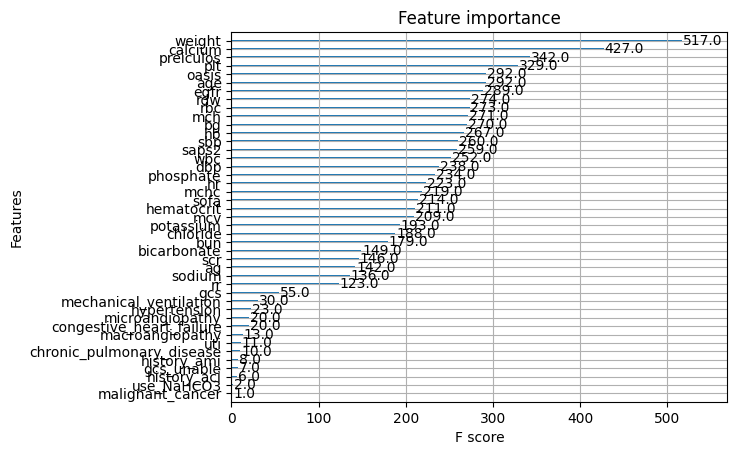

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

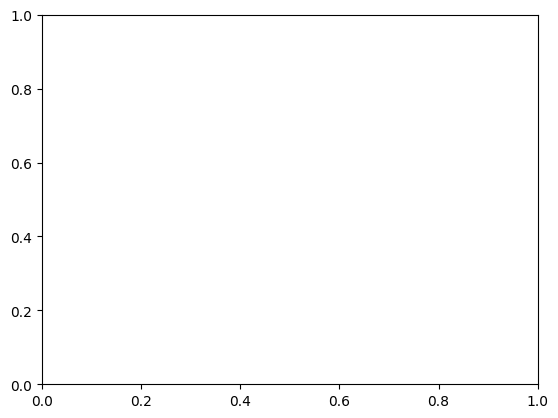

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66679


[1]	validation_0-logloss:0.66398


[2]	validation_0-logloss:0.66145


[3]	validation_0-logloss:0.65963


[4]	validation_0-logloss:0.65692


[5]	validation_0-logloss:0.65442


[6]	validation_0-logloss:0.65218


[7]	validation_0-logloss:0.65026


[8]	validation_0-logloss:0.64781


[9]	validation_0-logloss:0.64637


[10]	validation_0-logloss:0.64399


[11]	validation_0-logloss:0.64222


[12]	validation_0-logloss:0.64026


[13]	validation_0-logloss:0.63877


[14]	validation_0-logloss:0.63708


[15]	validation_0-logloss:0.63459


[16]	validation_0-logloss:0.63265


[17]	validation_0-logloss:0.63073


[18]	validation_0-logloss:0.62944


[19]	validation_0-logloss:0.62785


[20]	validation_0-logloss:0.62594


[21]	validation_0-logloss:0.62445


[22]	validation_0-logloss:0.62274


[23]	validation_0-logloss:0.62113


[24]	validation_0-logloss:0.62036


[25]	validation_0-logloss:0.61844


[26]	validation_0-logloss:0.61688


[27]	validation_0-logloss:0.61510


[28]	validation_0-logloss:0.61368


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-logloss:0.61133


[30]	validation_0-logloss:0.61037


[31]	validation_0-logloss:0.60853


[32]	validation_0-logloss:0.60695


[33]	validation_0-logloss:0.60608


[34]	validation_0-logloss:0.60455


[35]	validation_0-logloss:0.60313


[36]	validation_0-logloss:0.60154


[37]	validation_0-logloss:0.59974


[38]	validation_0-logloss:0.59842


[39]	validation_0-logloss:0.59729


[40]	validation_0-logloss:0.59597


[41]	validation_0-logloss:0.59501


[42]	validation_0-logloss:0.59363


[43]	validation_0-logloss:0.59223


[44]	validation_0-logloss:0.59064


[45]	validation_0-logloss:0.58983


[46]	validation_0-logloss:0.58875


[47]	validation_0-logloss:0.58735


[48]	validation_0-logloss:0.58615


[49]	validation_0-logloss:0.58552


[50]	validation_0-logloss:0.58463


[51]	validation_0-logloss:0.58352


[52]	validation_0-logloss:0.58219


[53]	validation_0-logloss:0.58110


[54]	validation_0-logloss:0.57951


[55]	validation_0-logloss:0.57809


[56]	validation_0-logloss:0.57706


[57]	validation_0-logloss:0.57633


[58]	validation_0-logloss:0.57576


[59]	validation_0-logloss:0.57479


[60]	validation_0-logloss:0.57419


[61]	validation_0-logloss:0.57328


[62]	validation_0-logloss:0.57224


[63]	validation_0-logloss:0.57138


[64]	validation_0-logloss:0.57065


[65]	validation_0-logloss:0.56967


[66]	validation_0-logloss:0.56901


[67]	validation_0-logloss:0.56803


[68]	validation_0-logloss:0.56717


[69]	validation_0-logloss:0.56620


[70]	validation_0-logloss:0.56550


[71]	validation_0-logloss:0.56466


[72]	validation_0-logloss:0.56385


[73]	validation_0-logloss:0.56287


[74]	validation_0-logloss:0.56242


[75]	validation_0-logloss:0.56191


[76]	validation_0-logloss:0.56136


[77]	validation_0-logloss:0.56028


[78]	validation_0-logloss:0.55935


[79]	validation_0-logloss:0.55891


[80]	validation_0-logloss:0.55803


[81]	validation_0-logloss:0.55686


[82]	validation_0-logloss:0.55631


[83]	validation_0-logloss:0.55543


[84]	validation_0-logloss:0.55495


[85]	validation_0-logloss:0.55448


[86]	validation_0-logloss:0.55357


[87]	validation_0-logloss:0.55313


[88]	validation_0-logloss:0.55252


[89]	validation_0-logloss:0.55190


[90]	validation_0-logloss:0.55113


[91]	validation_0-logloss:0.55050


[92]	validation_0-logloss:0.55001


[93]	validation_0-logloss:0.54956


[94]	validation_0-logloss:0.54891


[95]	validation_0-logloss:0.54839


[96]	validation_0-logloss:0.54761


[97]	validation_0-logloss:0.54713


[98]	validation_0-logloss:0.54658


[99]	validation_0-logloss:0.54603


[100]	validation_0-logloss:0.54559


[101]	validation_0-logloss:0.54554


[102]	validation_0-logloss:0.54502


[103]	validation_0-logloss:0.54437


[104]	validation_0-logloss:0.54358


[105]	validation_0-logloss:0.54306


[106]	validation_0-logloss:0.54266


[107]	validation_0-logloss:0.54180


[108]	validation_0-logloss:0.54124


[109]	validation_0-logloss:0.54081


[110]	validation_0-logloss:0.54093


[111]	validation_0-logloss:0.54021


[112]	validation_0-logloss:0.53987


[113]	validation_0-logloss:0.53928


[114]	validation_0-logloss:0.53899


[115]	validation_0-logloss:0.53857


[116]	validation_0-logloss:0.53821


[117]	validation_0-logloss:0.53801


[118]	validation_0-logloss:0.53772


[119]	validation_0-logloss:0.53723


[120]	validation_0-logloss:0.53696


[121]	validation_0-logloss:0.53625


[122]	validation_0-logloss:0.53636


[123]	validation_0-logloss:0.53626


[124]	validation_0-logloss:0.53608


[125]	validation_0-logloss:0.53560


[126]	validation_0-logloss:0.53539


[127]	validation_0-logloss:0.53477


[128]	validation_0-logloss:0.53467


[129]	validation_0-logloss:0.53419


[130]	validation_0-logloss:0.53375


[131]	validation_0-logloss:0.53345


[132]	validation_0-logloss:0.53312


[133]	validation_0-logloss:0.53294


[134]	validation_0-logloss:0.53292


[135]	validation_0-logloss:0.53260


[136]	validation_0-logloss:0.53220


[137]	validation_0-logloss:0.53208


[138]	validation_0-logloss:0.53153


[139]	validation_0-logloss:0.53149


[140]	validation_0-logloss:0.53129


[141]	validation_0-logloss:0.53130


[142]	validation_0-logloss:0.53095


[143]	validation_0-logloss:0.53083


[144]	validation_0-logloss:0.53061


[145]	validation_0-logloss:0.53013


[146]	validation_0-logloss:0.52992


[147]	validation_0-logloss:0.52924


[148]	validation_0-logloss:0.52875


[149]	validation_0-logloss:0.52801


[150]	validation_0-logloss:0.52760


[151]	validation_0-logloss:0.52766


[152]	validation_0-logloss:0.52740


[153]	validation_0-logloss:0.52742


[154]	validation_0-logloss:0.52728


[155]	validation_0-logloss:0.52698


[156]	validation_0-logloss:0.52672


[157]	validation_0-logloss:0.52678


[158]	validation_0-logloss:0.52632


[159]	validation_0-logloss:0.52581


[160]	validation_0-logloss:0.52542


[161]	validation_0-logloss:0.52531


[162]	validation_0-logloss:0.52518


[163]	validation_0-logloss:0.52478


[164]	validation_0-logloss:0.52440


[165]	validation_0-logloss:0.52438


[166]	validation_0-logloss:0.52439


[167]	validation_0-logloss:0.52422


[168]	validation_0-logloss:0.52416


[169]	validation_0-logloss:0.52386


[170]	validation_0-logloss:0.52364


[171]	validation_0-logloss:0.52336


[172]	validation_0-logloss:0.52294


[173]	validation_0-logloss:0.52265


[174]	validation_0-logloss:0.52242


[175]	validation_0-logloss:0.52215


[176]	validation_0-logloss:0.52155


[177]	validation_0-logloss:0.52111


[178]	validation_0-logloss:0.52084


[179]	validation_0-logloss:0.52078


[180]	validation_0-logloss:0.52052


[181]	validation_0-logloss:0.52036


[182]	validation_0-logloss:0.51974


[183]	validation_0-logloss:0.51912


[184]	validation_0-logloss:0.51920


[185]	validation_0-logloss:0.51970


[186]	validation_0-logloss:0.51935


[187]	validation_0-logloss:0.51929


[188]	validation_0-logloss:0.51898


[189]	validation_0-logloss:0.51854


[190]	validation_0-logloss:0.51865


[191]	validation_0-logloss:0.51859


[192]	validation_0-logloss:0.51867


[193]	validation_0-logloss:0.51851


[194]	validation_0-logloss:0.51850


[195]	validation_0-logloss:0.51805


[196]	validation_0-logloss:0.51783


[197]	validation_0-logloss:0.51775


[198]	validation_0-logloss:0.51772


[199]	validation_0-logloss:0.51748


[200]	validation_0-logloss:0.51751


[201]	validation_0-logloss:0.51754


[202]	validation_0-logloss:0.51742


[203]	validation_0-logloss:0.51688


[204]	validation_0-logloss:0.51659


[205]	validation_0-logloss:0.51662


[206]	validation_0-logloss:0.51637


[207]	validation_0-logloss:0.51633


[208]	validation_0-logloss:0.51647


[209]	validation_0-logloss:0.51642


[210]	validation_0-logloss:0.51674


[211]	validation_0-logloss:0.51712


[212]	validation_0-logloss:0.51686


[213]	validation_0-logloss:0.51689


[214]	validation_0-logloss:0.51684


[215]	validation_0-logloss:0.51651


[216]	validation_0-logloss:0.51644


[0]	validation_0-logloss:0.66822


[1]	validation_0-logloss:0.66595


[2]	validation_0-logloss:0.66368


[3]	validation_0-logloss:0.66124


[4]	validation_0-logloss:0.65857


[5]	validation_0-logloss:0.65611


[6]	validation_0-logloss:0.65395


[7]	validation_0-logloss:0.65222


[8]	validation_0-logloss:0.64995


[9]	validation_0-logloss:0.64829


[10]	validation_0-logloss:0.64664


[11]	validation_0-logloss:0.64505


[12]	validation_0-logloss:0.64298


[13]	validation_0-logloss:0.64137


[14]	validation_0-logloss:0.63926


[15]	validation_0-logloss:0.63740


[16]	validation_0-logloss:0.63556


[17]	validation_0-logloss:0.63361


[18]	validation_0-logloss:0.63154


[19]	validation_0-logloss:0.63010


[20]	validation_0-logloss:0.62873


[21]	validation_0-logloss:0.62737


[22]	validation_0-logloss:0.62587


[23]	validation_0-logloss:0.62425


[24]	validation_0-logloss:0.62186


[25]	validation_0-logloss:0.62016


[26]	validation_0-logloss:0.61852


[27]	validation_0-logloss:0.61658


[28]	validation_0-logloss:0.61538


[29]	validation_0-logloss:0.61389


[30]	validation_0-logloss:0.61244


[31]	validation_0-logloss:0.61124


[32]	validation_0-logloss:0.61011


[33]	validation_0-logloss:0.60847


[34]	validation_0-logloss:0.60755


[35]	validation_0-logloss:0.60576


[36]	validation_0-logloss:0.60436


[37]	validation_0-logloss:0.60270


[38]	validation_0-logloss:0.60088


[39]	validation_0-logloss:0.59950


[40]	validation_0-logloss:0.59805


[41]	validation_0-logloss:0.59694


[42]	validation_0-logloss:0.59568


[43]	validation_0-logloss:0.59461


[44]	validation_0-logloss:0.59277


[45]	validation_0-logloss:0.59152


[46]	validation_0-logloss:0.59011


[47]	validation_0-logloss:0.58884


[48]	validation_0-logloss:0.58744


[49]	validation_0-logloss:0.58681


[50]	validation_0-logloss:0.58558


[51]	validation_0-logloss:0.58423


[52]	validation_0-logloss:0.58328


[53]	validation_0-logloss:0.58239


[54]	validation_0-logloss:0.58129


[55]	validation_0-logloss:0.58069


[56]	validation_0-logloss:0.57963


[57]	validation_0-logloss:0.57874


[58]	validation_0-logloss:0.57781


[59]	validation_0-logloss:0.57698


[60]	validation_0-logloss:0.57558


[61]	validation_0-logloss:0.57508


[62]	validation_0-logloss:0.57409


[63]	validation_0-logloss:0.57302


[64]	validation_0-logloss:0.57181


[65]	validation_0-logloss:0.57086


[66]	validation_0-logloss:0.56977


[67]	validation_0-logloss:0.56883


[68]	validation_0-logloss:0.56839


[69]	validation_0-logloss:0.56758


[70]	validation_0-logloss:0.56676


[71]	validation_0-logloss:0.56588


[72]	validation_0-logloss:0.56483


[73]	validation_0-logloss:0.56396


[74]	validation_0-logloss:0.56368


[75]	validation_0-logloss:0.56260


[76]	validation_0-logloss:0.56227


[77]	validation_0-logloss:0.56096


[78]	validation_0-logloss:0.56042


[79]	validation_0-logloss:0.55945


[80]	validation_0-logloss:0.55888


[81]	validation_0-logloss:0.55809


[82]	validation_0-logloss:0.55729


[83]	validation_0-logloss:0.55634


[84]	validation_0-logloss:0.55532


[85]	validation_0-logloss:0.55495


[86]	validation_0-logloss:0.55458


[87]	validation_0-logloss:0.55373


[88]	validation_0-logloss:0.55263


[89]	validation_0-logloss:0.55206


[90]	validation_0-logloss:0.55145


[91]	validation_0-logloss:0.55083


[92]	validation_0-logloss:0.55046


[93]	validation_0-logloss:0.55001


[94]	validation_0-logloss:0.54927


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[95]	validation_0-logloss:0.54847


[96]	validation_0-logloss:0.54825


[97]	validation_0-logloss:0.54769


[98]	validation_0-logloss:0.54718


[99]	validation_0-logloss:0.54657


[100]	validation_0-logloss:0.54618


[101]	validation_0-logloss:0.54561


[102]	validation_0-logloss:0.54502


[103]	validation_0-logloss:0.54435

[104]	validation_0-logloss:0.54412


[105]	validation_0-logloss:0.54342


[106]	validation_0-logloss:0.54281

[107]	validation_0-logloss:0.54203


[108]	validation_0-logloss:0.54162


[109]	validation_0-logloss:0.54108


[110]	validation_0-logloss:0.54040


[111]	validation_0-logloss:0.53948


[112]	validation_0-logloss:0.53894


[113]	validation_0-logloss:0.53867


[114]	validation_0-logloss:0.53785


[115]	validation_0-logloss:0.53729


[116]	validation_0-logloss:0.53676


[117]	validation_0-logloss:0.53648


[118]	validation_0-logloss:0.53555


[119]	validation_0-logloss:0.53491


[120]	validation_0-logloss:0.53445


[121]	validation_0-logloss:0.53378


[122]	validation_0-logloss:0.53323


[123]	validation_0-logloss:0.53279


[124]	validation_0-logloss:0.53258


[125]	validation_0-logloss:0.53206


[126]	validation_0-logloss:0.53128


[127]	validation_0-logloss:0.53068


[128]	validation_0-logloss:0.53007


[129]	validation_0-logloss:0.52979


[130]	validation_0-logloss:0.52950


[131]	validation_0-logloss:0.52953


[132]	validation_0-logloss:0.52895


[133]	validation_0-logloss:0.52867


[134]	validation_0-logloss:0.52829


[135]	validation_0-logloss:0.52794


[136]	validation_0-logloss:0.52741


[137]	validation_0-logloss:0.52700


[138]	validation_0-logloss:0.52700


[139]	validation_0-logloss:0.52676


[140]	validation_0-logloss:0.52649


[141]	validation_0-logloss:0.52605


[142]	validation_0-logloss:0.52558


[143]	validation_0-logloss:0.52476


[144]	validation_0-logloss:0.52518


[145]	validation_0-logloss:0.52492


[146]	validation_0-logloss:0.52451


[147]	validation_0-logloss:0.52431


[148]	validation_0-logloss:0.52382


[149]	validation_0-logloss:0.52339


[150]	validation_0-logloss:0.52308


[151]	validation_0-logloss:0.52326


[152]	validation_0-logloss:0.52310


[153]	validation_0-logloss:0.52284


[154]	validation_0-logloss:0.52234


[155]	validation_0-logloss:0.52233


[156]	validation_0-logloss:0.52219


[157]	validation_0-logloss:0.52151


[158]	validation_0-logloss:0.52150


[159]	validation_0-logloss:0.52158


[160]	validation_0-logloss:0.52151


[161]	validation_0-logloss:0.52155


[162]	validation_0-logloss:0.52121


[163]	validation_0-logloss:0.52104


[164]	validation_0-logloss:0.52120


[165]	validation_0-logloss:0.52115


[166]	validation_0-logloss:0.52098


[167]	validation_0-logloss:0.52078


[168]	validation_0-logloss:0.52040


[169]	validation_0-logloss:0.52024


[170]	validation_0-logloss:0.51974


[171]	validation_0-logloss:0.51954


[172]	validation_0-logloss:0.51908


[173]	validation_0-logloss:0.51892


[174]	validation_0-logloss:0.51891


[175]	validation_0-logloss:0.51828


[176]	validation_0-logloss:0.51838


[177]	validation_0-logloss:0.51823


[178]	validation_0-logloss:0.51824


[179]	validation_0-logloss:0.51794


[180]	validation_0-logloss:0.51779


[181]	validation_0-logloss:0.51769


[182]	validation_0-logloss:0.51776


[183]	validation_0-logloss:0.51770


[184]	validation_0-logloss:0.51773


[185]	validation_0-logloss:0.51785


[186]	validation_0-logloss:0.51769


[187]	validation_0-logloss:0.51748


[188]	validation_0-logloss:0.51746


[189]	validation_0-logloss:0.51708


[190]	validation_0-logloss:0.51719


[191]	validation_0-logloss:0.51665


[192]	validation_0-logloss:0.51659


[193]	validation_0-logloss:0.51628


[194]	validation_0-logloss:0.51608


[195]	validation_0-logloss:0.51626


[196]	validation_0-logloss:0.51641


[197]	validation_0-logloss:0.51614


[198]	validation_0-logloss:0.51599


[199]	validation_0-logloss:0.51591


[200]	validation_0-logloss:0.51604


[201]	validation_0-logloss:0.51603


[202]	validation_0-logloss:0.51599


[203]	validation_0-logloss:0.51598


[204]	validation_0-logloss:0.51604


[205]	validation_0-logloss:0.51580


[206]	validation_0-logloss:0.51585


[207]	validation_0-logloss:0.51562


[208]	validation_0-logloss:0.51542


[209]	validation_0-logloss:0.51539


[210]	validation_0-logloss:0.51523


[211]	validation_0-logloss:0.51495


[212]	validation_0-logloss:0.51480


[213]	validation_0-logloss:0.51490


[214]	validation_0-logloss:0.51449


[215]	validation_0-logloss:0.51441


[216]	validation_0-logloss:0.51377


[217]	validation_0-logloss:0.51372


[218]	validation_0-logloss:0.51360


[219]	validation_0-logloss:0.51364


[220]	validation_0-logloss:0.51362


[221]	validation_0-logloss:0.51345


[222]	validation_0-logloss:0.51314


[223]	validation_0-logloss:0.51313


[224]	validation_0-logloss:0.51282


[225]	validation_0-logloss:0.51253


[226]	validation_0-logloss:0.51231


[227]	validation_0-logloss:0.51237


[228]	validation_0-logloss:0.51227


[229]	validation_0-logloss:0.51223


[230]	validation_0-logloss:0.51210


[231]	validation_0-logloss:0.51210


[232]	validation_0-logloss:0.51168


[233]	validation_0-logloss:0.51172


[234]	validation_0-logloss:0.51207


[235]	validation_0-logloss:0.51208


[236]	validation_0-logloss:0.51191


[237]	validation_0-logloss:0.51196


[238]	validation_0-logloss:0.51160


[239]	validation_0-logloss:0.51178


[240]	validation_0-logloss:0.51199


[241]	validation_0-logloss:0.51178


[242]	validation_0-logloss:0.51166


[243]	validation_0-logloss:0.51168


[244]	validation_0-logloss:0.51131


[245]	validation_0-logloss:0.51144


[246]	validation_0-logloss:0.51154


[247]	validation_0-logloss:0.51132


[248]	validation_0-logloss:0.51130


[249]	validation_0-logloss:0.51108


[250]	validation_0-logloss:0.51130


[251]	validation_0-logloss:0.51137


[252]	validation_0-logloss:0.51139


[253]	validation_0-logloss:0.51133


[254]	validation_0-logloss:0.51113


[255]	validation_0-logloss:0.51104


[256]	validation_0-logloss:0.51094


[257]	validation_0-logloss:0.51093


[258]	validation_0-logloss:0.51055


[259]	validation_0-logloss:0.51025


[260]	validation_0-logloss:0.51013


[261]	validation_0-logloss:0.51000


[262]	validation_0-logloss:0.50987


[263]	validation_0-logloss:0.50962


[264]	validation_0-logloss:0.50939


[265]	validation_0-logloss:0.50943


[266]	validation_0-logloss:0.50956


[267]	validation_0-logloss:0.50949


[268]	validation_0-logloss:0.50944


[269]	validation_0-logloss:0.50923


[270]	validation_0-logloss:0.50921


[271]	validation_0-logloss:0.50928


[272]	validation_0-logloss:0.50927


[273]	validation_0-logloss:0.50896


[274]	validation_0-logloss:0.50878


[275]	validation_0-logloss:0.50912


[276]	validation_0-logloss:0.50920


[277]	validation_0-logloss:0.50940


[278]	validation_0-logloss:0.50929


[279]	validation_0-logloss:0.50930


[280]	validation_0-logloss:0.50900


[281]	validation_0-logloss:0.50903


[282]	validation_0-logloss:0.50919


[283]	validation_0-logloss:0.50931


[284]	validation_0-logloss:0.50931


[0]	validation_0-logloss:0.66825


[1]	validation_0-logloss:0.66645


[2]	validation_0-logloss:0.66464


[3]	validation_0-logloss:0.66304


[4]	validation_0-logloss:0.66083


[5]	validation_0-logloss:0.65837


[6]	validation_0-logloss:0.65725


[7]	validation_0-logloss:0.65563


[8]	validation_0-logloss:0.65342


[9]	validation_0-logloss:0.65219


[10]	validation_0-logloss:0.65070


[11]	validation_0-logloss:0.64916


[12]	validation_0-logloss:0.64806


[13]	validation_0-logloss:0.64645


[14]	validation_0-logloss:0.64454


[15]	validation_0-logloss:0.64249


[16]	validation_0-logloss:0.64089


[17]	validation_0-logloss:0.63915


[18]	validation_0-logloss:0.63837


[19]	validation_0-logloss:0.63702


[20]	validation_0-logloss:0.63553


[21]	validation_0-logloss:0.63383


[22]	validation_0-logloss:0.63230


[23]	validation_0-logloss:0.63105


[24]	validation_0-logloss:0.62973


[25]	validation_0-logloss:0.62834


[26]	validation_0-logloss:0.62708


[27]	validation_0-logloss:0.62670


[28]	validation_0-logloss:0.62583


[29]	validation_0-logloss:0.62476


[30]	validation_0-logloss:0.62385


[31]	validation_0-logloss:0.62279


[32]	validation_0-logloss:0.62199


[33]	validation_0-logloss:0.62036


[34]	validation_0-logloss:0.61972


[35]	validation_0-logloss:0.61875


[36]	validation_0-logloss:0.61764


[37]	validation_0-logloss:0.61685


[38]	validation_0-logloss:0.61612


[39]	validation_0-logloss:0.61523


[40]	validation_0-logloss:0.61475


[41]	validation_0-logloss:0.61359


[42]	validation_0-logloss:0.61260


[43]	validation_0-logloss:0.61153


[44]	validation_0-logloss:0.61018


[45]	validation_0-logloss:0.60929


[46]	validation_0-logloss:0.60818


[47]	validation_0-logloss:0.60723


[48]	validation_0-logloss:0.60624


[49]	validation_0-logloss:0.60526


[50]	validation_0-logloss:0.60455


[51]	validation_0-logloss:0.60302


[52]	validation_0-logloss:0.60222


[53]	validation_0-logloss:0.60185


[54]	validation_0-logloss:0.60123


[55]	validation_0-logloss:0.60064


[56]	validation_0-logloss:0.59953


[57]	validation_0-logloss:0.59886


[58]	validation_0-logloss:0.59809


[59]	validation_0-logloss:0.59765


[60]	validation_0-logloss:0.59677


[61]	validation_0-logloss:0.59627


[62]	validation_0-logloss:0.59518


[63]	validation_0-logloss:0.59452


[64]	validation_0-logloss:0.59389


[65]	validation_0-logloss:0.59323


[66]	validation_0-logloss:0.59224


[67]	validation_0-logloss:0.59172


[68]	validation_0-logloss:0.59164


[69]	validation_0-logloss:0.59111


[70]	validation_0-logloss:0.59048


[71]	validation_0-logloss:0.58980


[72]	validation_0-logloss:0.58942


[73]	validation_0-logloss:0.58835


[74]	validation_0-logloss:0.58756


[75]	validation_0-logloss:0.58709


[76]	validation_0-logloss:0.58641


[77]	validation_0-logloss:0.58630


[78]	validation_0-logloss:0.58573


[79]	validation_0-logloss:0.58536


[80]	validation_0-logloss:0.58501


[81]	validation_0-logloss:0.58447


[82]	validation_0-logloss:0.58415


[83]	validation_0-logloss:0.58401


[84]	validation_0-logloss:0.58394


[85]	validation_0-logloss:0.58347


[86]	validation_0-logloss:0.58322


[87]	validation_0-logloss:0.58242


[88]	validation_0-logloss:0.58135


[89]	validation_0-logloss:0.58129


[90]	validation_0-logloss:0.58099


[91]	validation_0-logloss:0.58043


[92]	validation_0-logloss:0.58042


[93]	validation_0-logloss:0.57979


[94]	validation_0-logloss:0.57929


[95]	validation_0-logloss:0.57839


[96]	validation_0-logloss:0.57793


[97]	validation_0-logloss:0.57785


[98]	validation_0-logloss:0.57747


[99]	validation_0-logloss:0.57757


[100]	validation_0-logloss:0.57750


[101]	validation_0-logloss:0.57741


[102]	validation_0-logloss:0.57776


[103]	validation_0-logloss:0.57740


[104]	validation_0-logloss:0.57716


[105]	validation_0-logloss:0.57674


[106]	validation_0-logloss:0.57651


[107]	validation_0-logloss:0.57629


[108]	validation_0-logloss:0.57614


[109]	validation_0-logloss:0.57616


[110]	validation_0-logloss:0.57564


[111]	validation_0-logloss:0.57572


[112]	validation_0-logloss:0.57517


[113]	validation_0-logloss:0.57551


[114]	validation_0-logloss:0.57500


[115]	validation_0-logloss:0.57478


[116]	validation_0-logloss:0.57408


[117]	validation_0-logloss:0.57325


[118]	validation_0-logloss:0.57283


[119]	validation_0-logloss:0.57226


[120]	validation_0-logloss:0.57233


[121]	validation_0-logloss:0.57230


[122]	validation_0-logloss:0.57245


[123]	validation_0-logloss:0.57243


[124]	validation_0-logloss:0.57200


[125]	validation_0-logloss:0.57170


[126]	validation_0-logloss:0.57192


[127]	validation_0-logloss:0.57163


[128]	validation_0-logloss:0.57104


[129]	validation_0-logloss:0.57130


[130]	validation_0-logloss:0.57091


[131]	validation_0-logloss:0.57088


[132]	validation_0-logloss:0.57041


[133]	validation_0-logloss:0.57015


[134]	validation_0-logloss:0.57008


[135]	validation_0-logloss:0.56980


[136]	validation_0-logloss:0.56983


[137]	validation_0-logloss:0.56925


[138]	validation_0-logloss:0.56881


[139]	validation_0-logloss:0.56827


[140]	validation_0-logloss:0.56790


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[141]	validation_0-logloss:0.56790


[142]	validation_0-logloss:0.56776


[143]	validation_0-logloss:0.56731


[144]	validation_0-logloss:0.56688


[145]	validation_0-logloss:0.56679


[146]	validation_0-logloss:0.56669


[147]	validation_0-logloss:0.56648


[148]	validation_0-logloss:0.56637

[149]	validation_0-logloss:0.56609


[150]	validation_0-logloss:0.56626


[151]	validation_0-logloss:0.56630


[152]	validation_0-logloss:0.56628


[153]	validation_0-logloss:0.56599


[154]	validation_0-logloss:0.56593


[155]	validation_0-logloss:0.56582


[156]	validation_0-logloss:0.56565


[157]	validation_0-logloss:0.56547


[158]	validation_0-logloss:0.56510


[159]	validation_0-logloss:0.56474


[160]	validation_0-logloss:0.56451


[161]	validation_0-logloss:0.56428


[162]	validation_0-logloss:0.56419


[163]	validation_0-logloss:0.56436


[164]	validation_0-logloss:0.56371


[165]	validation_0-logloss:0.56373


[166]	validation_0-logloss:0.56367


[167]	validation_0-logloss:0.56344


[168]	validation_0-logloss:0.56304


[169]	validation_0-logloss:0.56282


[170]	validation_0-logloss:0.56321


[171]	validation_0-logloss:0.56292


[172]	validation_0-logloss:0.56269


[173]	validation_0-logloss:0.56281


[174]	validation_0-logloss:0.56258


[175]	validation_0-logloss:0.56270


[176]	validation_0-logloss:0.56226


[177]	validation_0-logloss:0.56221


[178]	validation_0-logloss:0.56219


[179]	validation_0-logloss:0.56231


[180]	validation_0-logloss:0.56219


[181]	validation_0-logloss:0.56199


[182]	validation_0-logloss:0.56225


[183]	validation_0-logloss:0.56179


[184]	validation_0-logloss:0.56201

[185]	validation_0-logloss:0.56220


[186]	validation_0-logloss:0.56218


[187]	validation_0-logloss:0.56192


[188]	validation_0-logloss:0.56208


[189]	validation_0-logloss:0.56222


[190]	validation_0-logloss:0.56247


[191]	validation_0-logloss:0.56247


[192]	validation_0-logloss:0.56239


[193]	validation_0-logloss:0.56193


[0]	validation_0-logloss:0.66833


[1]	validation_0-logloss:0.66651


[2]	validation_0-logloss:0.66412


[3]	validation_0-logloss:0.66255


[4]	validation_0-logloss:0.66014


[5]	validation_0-logloss:0.65809


[6]	validation_0-logloss:0.65572


[7]	validation_0-logloss:0.65435


[8]	validation_0-logloss:0.65232


[9]	validation_0-logloss:0.65141


[10]	validation_0-logloss:0.64974


[11]	validation_0-logloss:0.64814


[12]	validation_0-logloss:0.64632


[13]	validation_0-logloss:0.64480


[14]	validation_0-logloss:0.64287


[15]	validation_0-logloss:0.64068


[16]	validation_0-logloss:0.63929


[17]	validation_0-logloss:0.63713


[18]	validation_0-logloss:0.63526


[19]	validation_0-logloss:0.63394


[20]	validation_0-logloss:0.63221


[21]	validation_0-logloss:0.63097


[22]	validation_0-logloss:0.62896


[23]	validation_0-logloss:0.62710


[24]	validation_0-logloss:0.62529


[25]	validation_0-logloss:0.62372


[26]	validation_0-logloss:0.62246


[27]	validation_0-logloss:0.62086


[28]	validation_0-logloss:0.61919


[29]	validation_0-logloss:0.61751


[30]	validation_0-logloss:0.61618


[31]	validation_0-logloss:0.61503


[32]	validation_0-logloss:0.61366


[33]	validation_0-logloss:0.61251


[34]	validation_0-logloss:0.61134


[35]	validation_0-logloss:0.61002


[36]	validation_0-logloss:0.60862


[37]	validation_0-logloss:0.60719


[38]	validation_0-logloss:0.60665


[39]	validation_0-logloss:0.60555


[40]	validation_0-logloss:0.60438


[41]	validation_0-logloss:0.60356


[42]	validation_0-logloss:0.60236


[43]	validation_0-logloss:0.60167


[44]	validation_0-logloss:0.60053


[45]	validation_0-logloss:0.59900


[46]	validation_0-logloss:0.59759


[47]	validation_0-logloss:0.59629


[48]	validation_0-logloss:0.59522


[49]	validation_0-logloss:0.59392


[50]	validation_0-logloss:0.59294


[51]	validation_0-logloss:0.59165


[52]	validation_0-logloss:0.59099


[53]	validation_0-logloss:0.58961


[54]	validation_0-logloss:0.58878


[55]	validation_0-logloss:0.58784


[56]	validation_0-logloss:0.58715


[57]	validation_0-logloss:0.58663


[58]	validation_0-logloss:0.58552


[59]	validation_0-logloss:0.58488


[60]	validation_0-logloss:0.58336


[61]	validation_0-logloss:0.58235


[62]	validation_0-logloss:0.58083


[63]	validation_0-logloss:0.57990


[64]	validation_0-logloss:0.57911


[65]	validation_0-logloss:0.57852


[66]	validation_0-logloss:0.57767


[67]	validation_0-logloss:0.57741


[68]	validation_0-logloss:0.57624


[69]	validation_0-logloss:0.57579


[70]	validation_0-logloss:0.57512


[71]	validation_0-logloss:0.57435


[72]	validation_0-logloss:0.57391


[73]	validation_0-logloss:0.57321


[74]	validation_0-logloss:0.57263


[75]	validation_0-logloss:0.57180


[76]	validation_0-logloss:0.57104


[77]	validation_0-logloss:0.57091


[78]	validation_0-logloss:0.57013


[79]	validation_0-logloss:0.56966


[80]	validation_0-logloss:0.56861


[81]	validation_0-logloss:0.56815


[82]	validation_0-logloss:0.56782


[83]	validation_0-logloss:0.56690


[84]	validation_0-logloss:0.56634


[85]	validation_0-logloss:0.56558


[86]	validation_0-logloss:0.56473


[87]	validation_0-logloss:0.56434


[88]	validation_0-logloss:0.56358


[89]	validation_0-logloss:0.56312


[90]	validation_0-logloss:0.56314


[91]	validation_0-logloss:0.56272


[92]	validation_0-logloss:0.56216


[93]	validation_0-logloss:0.56101


[94]	validation_0-logloss:0.56034


[95]	validation_0-logloss:0.56018


[96]	validation_0-logloss:0.55952


[97]	validation_0-logloss:0.55902


[98]	validation_0-logloss:0.55857


[99]	validation_0-logloss:0.55808


[100]	validation_0-logloss:0.55744


[101]	validation_0-logloss:0.55667


[102]	validation_0-logloss:0.55642


[103]	validation_0-logloss:0.55631


[104]	validation_0-logloss:0.55610


[105]	validation_0-logloss:0.55590


[106]	validation_0-logloss:0.55560


[107]	validation_0-logloss:0.55526


[108]	validation_0-logloss:0.55452


[109]	validation_0-logloss:0.55415


[110]	validation_0-logloss:0.55370


[111]	validation_0-logloss:0.55341


[112]	validation_0-logloss:0.55290


[113]	validation_0-logloss:0.55233


[114]	validation_0-logloss:0.55203


[115]	validation_0-logloss:0.55169


[116]	validation_0-logloss:0.55116


[117]	validation_0-logloss:0.55094


[118]	validation_0-logloss:0.55063


[119]	validation_0-logloss:0.55038


[120]	validation_0-logloss:0.54997


[121]	validation_0-logloss:0.54961


[122]	validation_0-logloss:0.54909


[123]	validation_0-logloss:0.54814


[124]	validation_0-logloss:0.54770


[125]	validation_0-logloss:0.54737


[126]	validation_0-logloss:0.54703


[127]	validation_0-logloss:0.54641


[128]	validation_0-logloss:0.54626


[129]	validation_0-logloss:0.54643


[130]	validation_0-logloss:0.54618


[131]	validation_0-logloss:0.54599


[132]	validation_0-logloss:0.54550


[133]	validation_0-logloss:0.54525


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:18:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[134]	validation_0-logloss:0.54512


[135]	validation_0-logloss:0.54469


[136]	validation_0-logloss:0.54472


[137]	validation_0-logloss:0.54443


[138]	validation_0-logloss:0.54406


[139]	validation_0-logloss:0.54400


[140]	validation_0-logloss:0.54363


[141]	validation_0-logloss:0.54331


[142]	validation_0-logloss:0.54312


[143]	validation_0-logloss:0.54301


[144]	validation_0-logloss:0.54248


[145]	validation_0-logloss:0.54186


[146]	validation_0-logloss:0.54174


[147]	validation_0-logloss:0.54131


[148]	validation_0-logloss:0.54105


[149]	validation_0-logloss:0.54041


[150]	validation_0-logloss:0.54006


[151]	validation_0-logloss:0.53965


[152]	validation_0-logloss:0.53927


[153]	validation_0-logloss:0.53897


[154]	validation_0-logloss:0.53874


[155]	validation_0-logloss:0.53797


[156]	validation_0-logloss:0.53801


[157]	validation_0-logloss:0.53779


[158]	validation_0-logloss:0.53721


[159]	validation_0-logloss:0.53653


[160]	validation_0-logloss:0.53605


[161]	validation_0-logloss:0.53566


[162]	validation_0-logloss:0.53565


[163]	validation_0-logloss:0.53526


[164]	validation_0-logloss:0.53503


[165]	validation_0-logloss:0.53506


[166]	validation_0-logloss:0.53482


[167]	validation_0-logloss:0.53446


[168]	validation_0-logloss:0.53480


[169]	validation_0-logloss:0.53513


[170]	validation_0-logloss:0.53491


[171]	validation_0-logloss:0.53462


[172]	validation_0-logloss:0.53479


[173]	validation_0-logloss:0.53450


[174]	validation_0-logloss:0.53430


[175]	validation_0-logloss:0.53391


[176]	validation_0-logloss:0.53369


[177]	validation_0-logloss:0.53338


[178]	validation_0-logloss:0.53305


[179]	validation_0-logloss:0.53331


[180]	validation_0-logloss:0.53306


[181]	validation_0-logloss:0.53256


[182]	validation_0-logloss:0.53230


[183]	validation_0-logloss:0.53202


[184]	validation_0-logloss:0.53158


[185]	validation_0-logloss:0.53125


[186]	validation_0-logloss:0.53140


[187]	validation_0-logloss:0.53125


[188]	validation_0-logloss:0.53154


[189]	validation_0-logloss:0.53120


[190]	validation_0-logloss:0.53087


[191]	validation_0-logloss:0.53090


[192]	validation_0-logloss:0.53086


[193]	validation_0-logloss:0.53062


[194]	validation_0-logloss:0.53052


[195]	validation_0-logloss:0.53058


[196]	validation_0-logloss:0.53023


[197]	validation_0-logloss:0.53028


[198]	validation_0-logloss:0.53034


[199]	validation_0-logloss:0.53028


[200]	validation_0-logloss:0.53036


[201]	validation_0-logloss:0.53034


[202]	validation_0-logloss:0.52988


[203]	validation_0-logloss:0.52970


[204]	validation_0-logloss:0.53004


[205]	validation_0-logloss:0.53024


[206]	validation_0-logloss:0.52993


[207]	validation_0-logloss:0.52992


[208]	validation_0-logloss:0.52992


[209]	validation_0-logloss:0.52969


[210]	validation_0-logloss:0.52943


[211]	validation_0-logloss:0.52928


[212]	validation_0-logloss:0.52935


[213]	validation_0-logloss:0.52961


[214]	validation_0-logloss:0.52906


[215]	validation_0-logloss:0.52895


[216]	validation_0-logloss:0.52939


[217]	validation_0-logloss:0.52930


[218]	validation_0-logloss:0.52943


[219]	validation_0-logloss:0.52950


[220]	validation_0-logloss:0.52963


[221]	validation_0-logloss:0.52913


[222]	validation_0-logloss:0.52943


[223]	validation_0-logloss:0.52976


[224]	validation_0-logloss:0.52986


[0]	validation_0-logloss:0.66781


[1]	validation_0-logloss:0.66528


[2]	validation_0-logloss:0.66349


[3]	validation_0-logloss:0.66140


[4]	validation_0-logloss:0.65988


[5]	validation_0-logloss:0.65775


[6]	validation_0-logloss:0.65617


[7]	validation_0-logloss:0.65409


[8]	validation_0-logloss:0.65206


[9]	validation_0-logloss:0.65046


[10]	validation_0-logloss:0.64834


[11]	validation_0-logloss:0.64678


[12]	validation_0-logloss:0.64463


[13]	validation_0-logloss:0.64273


[14]	validation_0-logloss:0.64104


[15]	validation_0-logloss:0.63905


[16]	validation_0-logloss:0.63766


[17]	validation_0-logloss:0.63648


[18]	validation_0-logloss:0.63433


[19]	validation_0-logloss:0.63311


[20]	validation_0-logloss:0.63180


[21]	validation_0-logloss:0.63014


[22]	validation_0-logloss:0.62826


[23]	validation_0-logloss:0.62641


[24]	validation_0-logloss:0.62536


[25]	validation_0-logloss:0.62365


[26]	validation_0-logloss:0.62236


[27]	validation_0-logloss:0.62143


[28]	validation_0-logloss:0.61963


[29]	validation_0-logloss:0.61830


[30]	validation_0-logloss:0.61640


[31]	validation_0-logloss:0.61542


[32]	validation_0-logloss:0.61442


[33]	validation_0-logloss:0.61301


[34]	validation_0-logloss:0.61146


[35]	validation_0-logloss:0.61048


[36]	validation_0-logloss:0.60892


[37]	validation_0-logloss:0.60836


[38]	validation_0-logloss:0.60787


[39]	validation_0-logloss:0.60655


[40]	validation_0-logloss:0.60543


[41]	validation_0-logloss:0.60452


[42]	validation_0-logloss:0.60359


[43]	validation_0-logloss:0.60280


[44]	validation_0-logloss:0.60192


[45]	validation_0-logloss:0.60091


[46]	validation_0-logloss:0.59926


[47]	validation_0-logloss:0.59817


[48]	validation_0-logloss:0.59753


[49]	validation_0-logloss:0.59644


[50]	validation_0-logloss:0.59579


[51]	validation_0-logloss:0.59510


[52]	validation_0-logloss:0.59453


[53]	validation_0-logloss:0.59360


[54]	validation_0-logloss:0.59277


[55]	validation_0-logloss:0.59151


[56]	validation_0-logloss:0.59048


[57]	validation_0-logloss:0.58976


[58]	validation_0-logloss:0.58928


[59]	validation_0-logloss:0.58905


[60]	validation_0-logloss:0.58818


[61]	validation_0-logloss:0.58733


[62]	validation_0-logloss:0.58628


[63]	validation_0-logloss:0.58498


[64]	validation_0-logloss:0.58407


[65]	validation_0-logloss:0.58300


[66]	validation_0-logloss:0.58250


[67]	validation_0-logloss:0.58199


[68]	validation_0-logloss:0.58099


[69]	validation_0-logloss:0.58036


[70]	validation_0-logloss:0.57961


[71]	validation_0-logloss:0.57923


[72]	validation_0-logloss:0.57866


[73]	validation_0-logloss:0.57812


[74]	validation_0-logloss:0.57757


[75]	validation_0-logloss:0.57644


[76]	validation_0-logloss:0.57616


[77]	validation_0-logloss:0.57625


[78]	validation_0-logloss:0.57538


[79]	validation_0-logloss:0.57495


[80]	validation_0-logloss:0.57424


[81]	validation_0-logloss:0.57387


[82]	validation_0-logloss:0.57378


[83]	validation_0-logloss:0.57307


[84]	validation_0-logloss:0.57274


[85]	validation_0-logloss:0.57243


[86]	validation_0-logloss:0.57163


[87]	validation_0-logloss:0.57104


[88]	validation_0-logloss:0.57068


[89]	validation_0-logloss:0.56983


[90]	validation_0-logloss:0.56987


[91]	validation_0-logloss:0.56955


[92]	validation_0-logloss:0.56901


[93]	validation_0-logloss:0.56851


[94]	validation_0-logloss:0.56833


[95]	validation_0-logloss:0.56730


[96]	validation_0-logloss:0.56698


[97]	validation_0-logloss:0.56645


[98]	validation_0-logloss:0.56627


[99]	validation_0-logloss:0.56582


[100]	validation_0-logloss:0.56553


[101]	validation_0-logloss:0.56517


[102]	validation_0-logloss:0.56487


[103]	validation_0-logloss:0.56470


[104]	validation_0-logloss:0.56394


[105]	validation_0-logloss:0.56342


[106]	validation_0-logloss:0.56326


[107]	validation_0-logloss:0.56276


[108]	validation_0-logloss:0.56197


[109]	validation_0-logloss:0.56139


[110]	validation_0-logloss:0.56107


[111]	validation_0-logloss:0.56063


[112]	validation_0-logloss:0.56023


[113]	validation_0-logloss:0.55998


[114]	validation_0-logloss:0.55928


[115]	validation_0-logloss:0.55919


[116]	validation_0-logloss:0.55853


[117]	validation_0-logloss:0.55844


[118]	validation_0-logloss:0.55787


[119]	validation_0-logloss:0.55766


[120]	validation_0-logloss:0.55726


[121]	validation_0-logloss:0.55701


[122]	validation_0-logloss:0.55687


[123]	validation_0-logloss:0.55724


[124]	validation_0-logloss:0.55704


[125]	validation_0-logloss:0.55677


[126]	validation_0-logloss:0.55608


[127]	validation_0-logloss:0.55572


[128]	validation_0-logloss:0.55556


[129]	validation_0-logloss:0.55511


[130]	validation_0-logloss:0.55489


[131]	validation_0-logloss:0.55468


[132]	validation_0-logloss:0.55439


[133]	validation_0-logloss:0.55371


[134]	validation_0-logloss:0.55310


[135]	validation_0-logloss:0.55255


[136]	validation_0-logloss:0.55248


[137]	validation_0-logloss:0.55227


[138]	validation_0-logloss:0.55203


[139]	validation_0-logloss:0.55189


[140]	validation_0-logloss:0.55130


[141]	validation_0-logloss:0.55116


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:19:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[142]	validation_0-logloss:0.55074


[143]	validation_0-logloss:0.55049


[144]	validation_0-logloss:0.55002


[145]	validation_0-logloss:0.54994


[146]	validation_0-logloss:0.54982


[147]	validation_0-logloss:0.54977


[148]	validation_0-logloss:0.54993


[149]	validation_0-logloss:0.54963


[150]	validation_0-logloss:0.54937


[151]	validation_0-logloss:0.54920


[152]	validation_0-logloss:0.54904


[153]	validation_0-logloss:0.54906


[154]	validation_0-logloss:0.54880


[155]	validation_0-logloss:0.54872


[156]	validation_0-logloss:0.54845


[157]	validation_0-logloss:0.54832


[158]	validation_0-logloss:0.54844


[159]	validation_0-logloss:0.54831


[160]	validation_0-logloss:0.54801


[161]	validation_0-logloss:0.54776


[162]	validation_0-logloss:0.54771


[163]	validation_0-logloss:0.54754


[164]	validation_0-logloss:0.54734


[165]	validation_0-logloss:0.54749


[166]	validation_0-logloss:0.54686


[167]	validation_0-logloss:0.54641


[168]	validation_0-logloss:0.54653


[169]	validation_0-logloss:0.54645


[170]	validation_0-logloss:0.54622


[171]	validation_0-logloss:0.54593


[172]	validation_0-logloss:0.54587


[173]	validation_0-logloss:0.54577


[174]	validation_0-logloss:0.54592


[175]	validation_0-logloss:0.54582


[176]	validation_0-logloss:0.54598


[177]	validation_0-logloss:0.54604


[178]	validation_0-logloss:0.54631


[179]	validation_0-logloss:0.54602


[180]	validation_0-logloss:0.54586


[181]	validation_0-logloss:0.54580


[182]	validation_0-logloss:0.54557


[183]	validation_0-logloss:0.54550


[184]	validation_0-logloss:0.54520


[185]	validation_0-logloss:0.54492


[186]	validation_0-logloss:0.54471


[187]	validation_0-logloss:0.54465


[188]	validation_0-logloss:0.54434


[189]	validation_0-logloss:0.54423


[190]	validation_0-logloss:0.54429


[191]	validation_0-logloss:0.54392


[192]	validation_0-logloss:0.54380

[193]	validation_0-logloss:0.54349


[194]	validation_0-logloss:0.54341


[195]	validation_0-logloss:0.54335


[196]	validation_0-logloss:0.54334


[197]	validation_0-logloss:0.54330


[198]	validation_0-logloss:0.54316


[199]	validation_0-logloss:0.54320


[200]	validation_0-logloss:0.54326


[201]	validation_0-logloss:0.54331


[202]	validation_0-logloss:0.54352


[203]	validation_0-logloss:0.54323

[204]	validation_0-logloss:0.54345


[205]	validation_0-logloss:0.54377


[206]	validation_0-logloss:0.54384


[207]	validation_0-logloss:0.54350


[208]	validation_0-logloss:0.54367


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7938393470873754
Average Accuracy: 0.7329892664860601
Average Precision: 0.6967591915662309
Average Recall: 0.5718029115341545
